In [1]:
import logging
import os
import traceback

import pandas as pd
from certa.explain import CertaExplainer
from certa.local_explain import get_original_prediction, get_row
from certa.utils import merge_sources
from certa.models.utils import from_type

In [75]:
root_datadir = '../cheapER/datasets/'
experiments_dir = 'experiments/'
dataset = 'abt_buy'
datadir = os.path.join(root_datadir, dataset)
mtype = 'deeper'
mdir_dict = {'ditto':'Ditto', 'deeper': 'DeepER', 'dm':'DeepMatcher'}
model_dir = mdir_dict[mtype]

In [76]:
model = from_type(mtype)

* Costruzione indice degli embeddings.....Fatto. 400001 embeddings totali.
* Creazione del modello per il calcolo degli embeddings....
* Inizializzo il tokenizzatore.....Fatto: 400001 parole totali.
* Preparazione della matrice di embedding.....Fatto. Dimensioni matrice embeddings: (400002, 300)

°°° EMBEDDING MODEL °°°
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Tupla_A (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
Tupla_B (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
Embedding_lookup (Embedding)    (None, None, 300)    120000600   Tu

In [78]:
save_path = 'models/saved/'+mtype+'/' + dataset +'/'
model.load(save_path)

In [79]:
def predict_fn(x):
    return model.predict(x)

In [50]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import traceback
import random
from certa.local_explain import get_row

def alter_data(explanations, l_tuple, r_tuple, predict_fn, agg=True, lprefix='ltable_', rprefix='rtable_',
        num_masked: int = 3, perturb: str = 'mask', mask_token: str = ''):
    data = pd.DataFrame()
    lt = l_tuple.copy()
    rt = r_tuple.copy()
    row = get_row(lt, rt)
    orig = predict_fn(row)[['nomatch_score', 'match_score']].values[0][1]
    margin = 0.5
    for explanation in explanations:
        saliency = explanation.copy()
        exp_type = saliency.pop('type')
        scores_d = []
        #scores_c = []
        for tk in np.arange(num_masked):
            # get top k important attributes
            if not agg and tk >= len(saliency):
                break
            if exp_type == 'certa':
                if agg:
                    explanation_attributes = sorted(saliency, key=saliency.get, reverse=True)[:tk]
                else:
                    explanation_attributes = [sorted(saliency, key=saliency.get, reverse=True)[tk]]
            elif orig < 0.5:
                saliency = {k:v for k,v in saliency.items() }
                if agg:
                    explanation_attributes = sorted(saliency, key=saliency.get)[:tk]
                else:
                    explanation_attributes = [sorted(saliency, key=saliency.get)[tk]]
            else:
                saliency = {k:v for k,v in saliency.items() }
                if agg:
                    explanation_attributes = sorted(saliency, key=saliency.get, reverse=True)[:tk]
                else:
                    explanation_attributes = [sorted(saliency, key=saliency.get, reverse=True)[tk]]
            # alter those attributes
            if len(explanation_attributes) > 0:
                if isinstance(perturb, pd.Series):
                    try:
                        random_record = perturb
                        lt = l_tuple.copy()
                        rt = r_tuple.copy()
                        modified_row = get_row(lt, rt)
                        for e in explanation_attributes:
                            modified_row[e] = random_record[e]
                        modified_tuple_prediction = predict_fn(modified_row)[['nomatch_score', 'match_score']].values[0]
                        score_drop = modified_tuple_prediction[1]
                        scores_d.append(score_drop)
                    except Exception as e:
                        print(traceback.format_exc())
                elif perturb == 'mask':
                    try:
                        lt = l_tuple.copy()
                        rt = r_tuple.copy()
                        modified_row = get_row(lt, rt)
                        for e in explanation_attributes:
                            modified_row[e] = mask_token
                        modified_tuple_prediction = predict_fn(modified_row)[['nomatch_score', 'match_score']].values[0]
                        score_drop = modified_tuple_prediction[1]
                        scores_d.append(score_drop)
                    except Exception as e:
                        print(traceback.format_exc())
                elif perturb == 'copy':
                    try:
                        lt = l_tuple.copy()
                        rt = r_tuple.copy()
                        modified_row = get_row(lt, rt)
                        for e in explanation_attributes:
                            if e.startswith(lprefix):
                                new_e = e.replace(lprefix, rprefix)
                            else:
                                new_e = e.replace(rprefix, lprefix)
                            modified_row[e] = modified_row[new_e]
                        modified_tuple_prediction = predict_fn(modified_row)[['nomatch_score', 'match_score']].values[0]
                        score_copy = modified_tuple_prediction[1]
                        scores_d.append(score_copy)
                    except Exception as e:
                        print(traceback.format_exc())
        data[exp_type]= pd.Series(scores_d)
    print(scores_d)
    data['prediction'] = orig
    data['margin'] = margin
    return data


def saliency_graph(saliency_df: pd.DataFrame, l_tuple, r_tuple, predict_fn, etype='certa', nm=9, color='skyblue',
                   so=False, mapping_dict=None, perturb='mask', path=None, pred=None):
    print(pred)
    print(perturb)
    saliency = saliency_df.copy()
    if 'ltable_id' in saliency.columns:
        saliency = saliency.drop('ltable_id', axis=1)
    if 'rtable_id' in saliency.columns:
        saliency = saliency.drop('rtable_id', axis=1)
    exp = saliency.to_dict(orient='list')
    exp['type'] = etype
    if perturb == 'rand':
        perturb = train_df.iloc[random.randint(0,len(train_df)-1)]
    single = alter_data([exp], l_tuple, r_tuple, predict_fn, num_masked=nm, agg=False, perturb=perturb)[etype]
    aggr = alter_data([exp], l_tuple, r_tuple, predict_fn, num_masked=nm+1, perturb=perturb)[etype]
    #rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
    #my_cmap = plt.get_cmap("Blues")
    plt.figure(figsize=(10, 6))
    plt.xticks(rotation=60, fontsize=15)
    if mapping_dict is not None:
        saliency_df = saliency_df.rename(columns=mapping_dict)
    if pred is not None:
        so = etype != 'certa' and float(pred) < 0.5
    saliency_sorted_df = saliency_df.sort_values(saliency_df.last_valid_index(), axis=1, ascending=so)

    x = saliency_sorted_df.columns[:nm]
    y = saliency_sorted_df.values[0][:nm]

    axes2 = plt.twinx()
    plt.bar(x=x, height=y, label='Saliency', color=color)
    
    y1 = aggr
    y2 = single
    ml = np.empty(len(y1))
    ml.fill(0.5)
    
    x1 = x[:len(y1)]
    x2 = x[:len(y2)]
    axes2.plot(x1, y1[:len(x1)], '^g-', label='Aggregate', linewidth=5.0)
    axes2.plot(x2, y2[:len(x2)], '^r-', label='Single', linewidth=5.0)
    pred_line = 0
    if pred is not None:
        pred_line = np.empty(len(y1))
        pred_line.fill(pred)
        x3 = x[:len(y1)]
        axes2.plot(x3, pred_line[:len(x3)], '^b-', label='Prediction', linewidth=1.0)
        axes2.plot(x3, ml, color='black', label='Decision boundary', linewidth=1.0)
    
    if path is not None:
        plt.savefig(path, bbox_inches='tight')
        
    if etype == 'certa':
        plt.ylim([0.0, 1.0])
    else:
        plt.ylim(min(y) * 1.1, 1.0) #max(max(y1),max(y2),max(pred_line)))
        
    plt.show()
    aggr = np.array(y1)
    sing = np.array(y2)

    if len(aggr) < len(saliency_df.columns):
        pl = len(saliency_df.columns) - len(aggr)
        aggr = np.pad(aggr, (0, pl))
    if len(sing) < len(saliency_df.columns):
        pl = len(saliency_df.columns) - len(sing)
        sing = np.pad(sing, (0, pl))

    saliency_sorted_df.loc[1] = aggr
    saliency_sorted_df.loc[2] = sing
    saliency_sorted_df['result'] = ['saliency', 'aggregate', 'single']

    return saliency_sorted_df

In [7]:
lsource = pd.read_csv(datadir + '/tableA.csv')
rsource = pd.read_csv(datadir + '/tableB.csv')
gt = pd.read_csv(datadir + '/train.csv')
valid = pd.read_csv(datadir + '/valid.csv')
test = pd.read_csv(datadir + '/test.csv')

test_df = merge_sources(test, 'ltable_', 'rtable_', lsource, rsource, ['label'], [])
train_df = merge_sources(gt, 'ltable_', 'rtable_', lsource, rsource, ['label'], ['id'])

0.1
mask
[0.01658893, 0.094059594, 0.6864893, 0.6625261]
[0.01658893, 0.57955724, 0.5741539, 0.3631932]


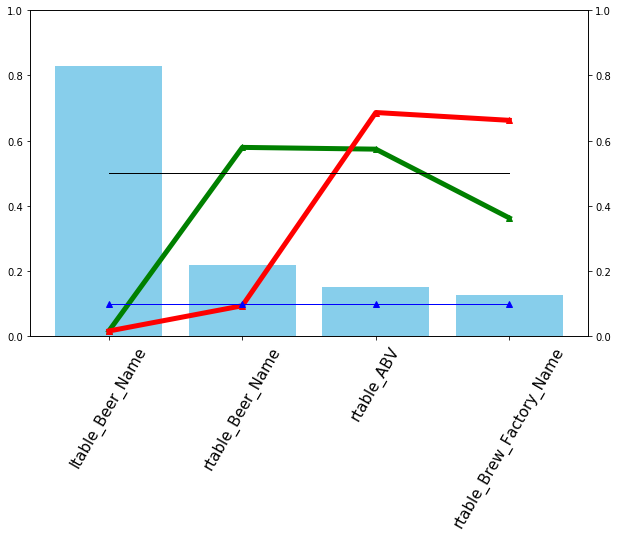

ltable_Beer_Name  rtable_Beer_Name  rtable_ABV  rtable_Brew_Factory_Name  \
0          0.829181          0.218456    0.150426                  0.127361   
1          0.016589          0.579557    0.574154                  0.363193   
2          0.016589          0.094060    0.686489                  0.662526   

   ltable_Style  rtable_Style  ltable_Brew_Factory_Name  ltable_ABV     result  
0      0.111085      0.083244                 -0.108895   -0.118036   saliency  
1      0.000000      0.000000                  0.000000    0.000000  aggregate  
2      0.000000      0.000000                  0.000000    0.000000     single

In [94]:
i = 8
rand_row =  test_df.iloc[i]
l_id = int(rand_row['ltable_id'])
label = rand_row["label"]
l_tuple = lsource.iloc[l_id]
r_id = int(rand_row['rtable_id'])
r_tuple = rsource.iloc[r_id]
rand_row.head()

item = get_row(l_tuple, r_tuple)
saliency_graph(saliency_df, l_tuple, r_tuple, predict_fn, nm=4, pred=0.1, perturb='mask', path='/home/tteofili/dev/certem/data_new/BA/'+model_dir+'/'+str(i)+'/sg/certa.png')

In [80]:
explanations = dict()
explanations['certa'] = pd.read_csv('/home/tteofili/dev/certem/data_new/BA/'+model_dir+'/certa.csv')
explanations['mojito'] = pd.read_csv('/home/tteofili/dev/certem/data_new/BA/'+model_dir+'/mojito.csv')
explanations['landmark'] =  pd.read_csv('/home/tteofili/dev/certem/data_new/BA/'+model_dir+'/landmark.csv')
explanations['shap'] =  pd.read_csv('/home/tteofili/dev/certem/data_new/BA/'+model_dir+'/shap.csv')

In [24]:
#saliency_df = pd.DataFrame(eval(certa_explanations.iloc[i]['explanation']),index=[0])

0.016588930040597916
mask
[0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893]
[0.01658893, 0.01658893, 0.02506505, 0.99969864, 0.99929583, 0.9999994, 0.9967392]


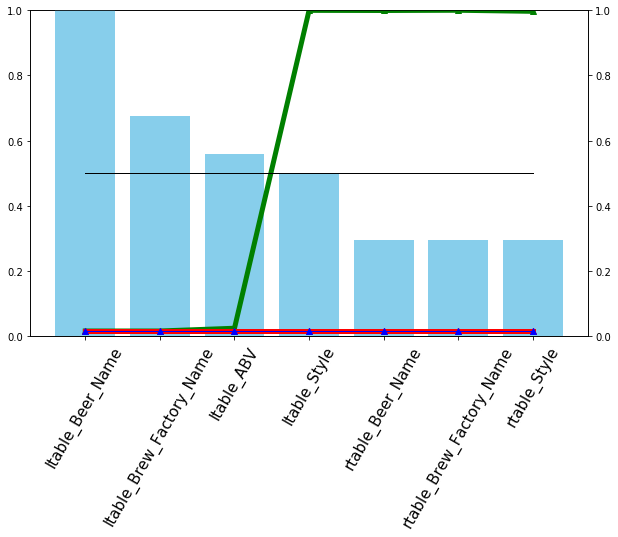

0.016588930040597916
copy
[0.13565099, 0.01658893, 0.01658893, 0.01658893, 0.38168356, 0.01658893, 0.01658893]
[0.13565099, 0.15424515, 0.15215059, 0.05451801, 0.05451801, 0.05451801, 0.05451801]


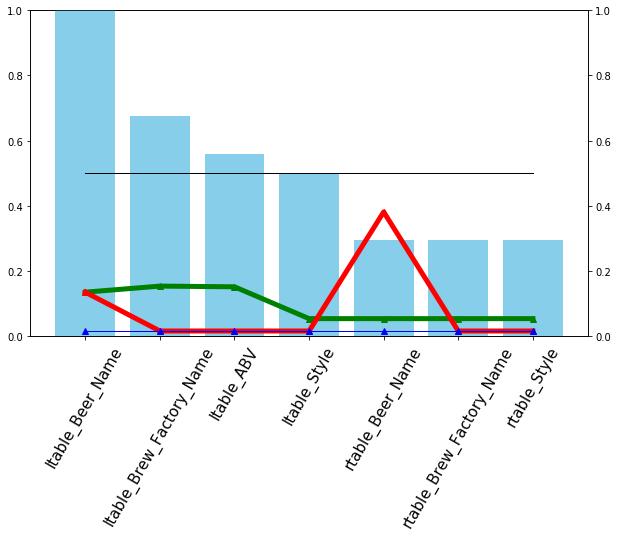

0.016588930040597916
rand
[0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.020341855, 0.01658893, 0.01658893]
[0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893]


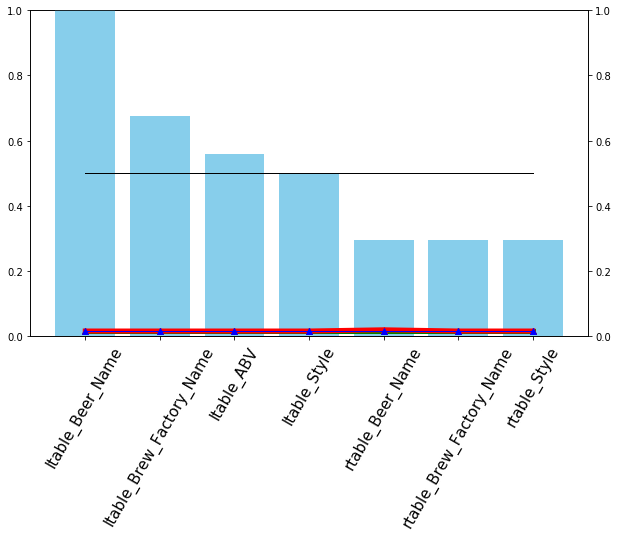

0.016588930040597916
mask
[0.8929399, 0.088095576, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893]
[0.8929399, 0.72565216, 0.722338, 0.41944933, 0.99998736, 0.9999913, 0.9997179]


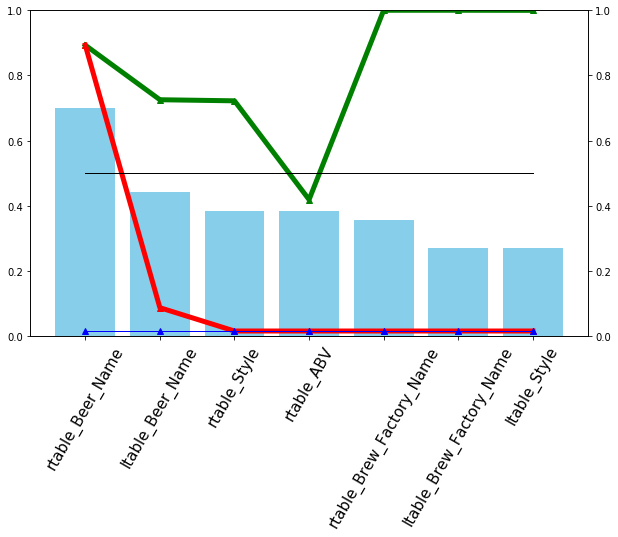

0.016588930040597916
copy
[0.9999497, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893]
[0.9999497, 0.9999497, 0.9999765, 0.99997497, 0.9999492, 0.9999492, 0.9999492]


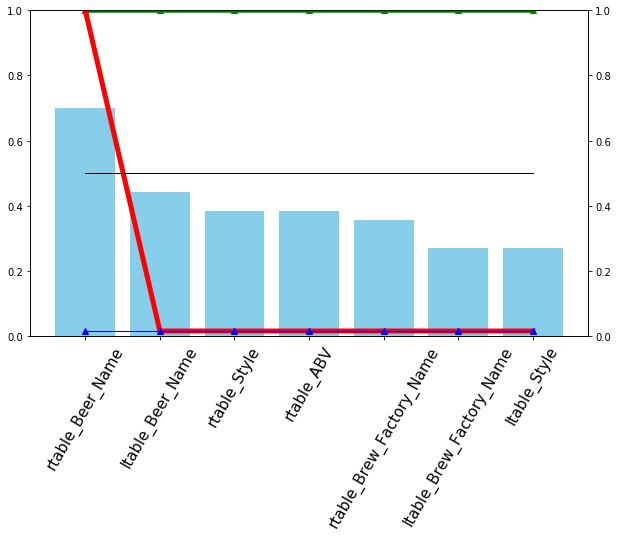

0.016588930040597916
rand
[0.28312427, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893]
[0.28312427, 0.49758038, 0.5097469, 0.4870273, 0.6074331, 0.6079807, 0.6079807]


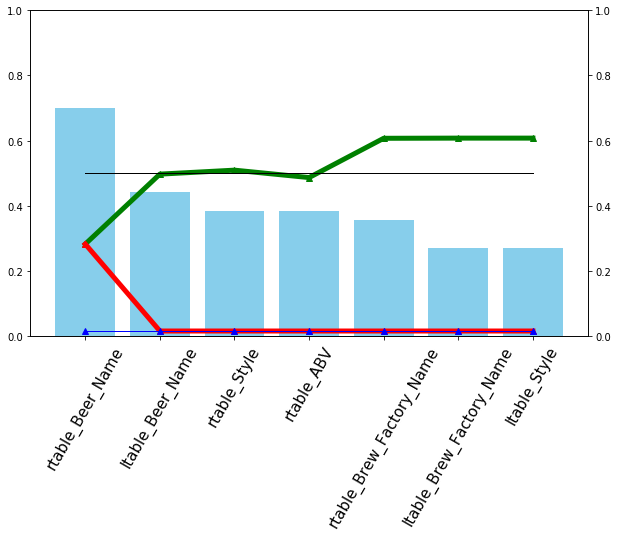

0.5825655460357666
mask
[0.040085513, 0.2317003, 0.4581605, 0.39849988, 0.5334703, 0.63825387, 0.56617254]
[0.040085513, 0.07509376, 0.02118668, 0.9993631, 0.99944407, 0.99941945, 0.9997949]


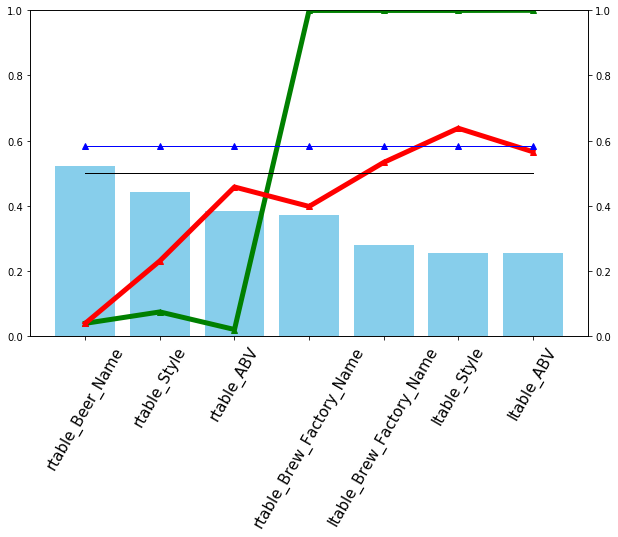

0.5825655460357666
copy
[0.70894027, 0.6319091, 0.58256555, 0.51080585, 0.46503752, 0.6113004, 0.58256555]
[0.70894027, 0.6998964, 0.6998964, 0.8425348, 0.8425348, 0.8425348, 0.8425348]


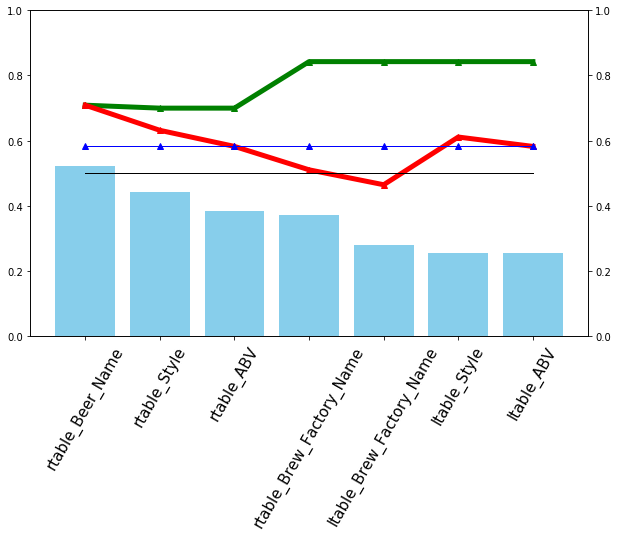

0.5825655460357666
rand
[0.19488722, 0.58256555, 0.5959248, 0.5778589, 0.6376154, 0.58256555, 0.72079486]
[0.19488722, 0.19488722, 0.19706886, 0.091040224, 0.10175041, 0.10175041, 0.1778143]


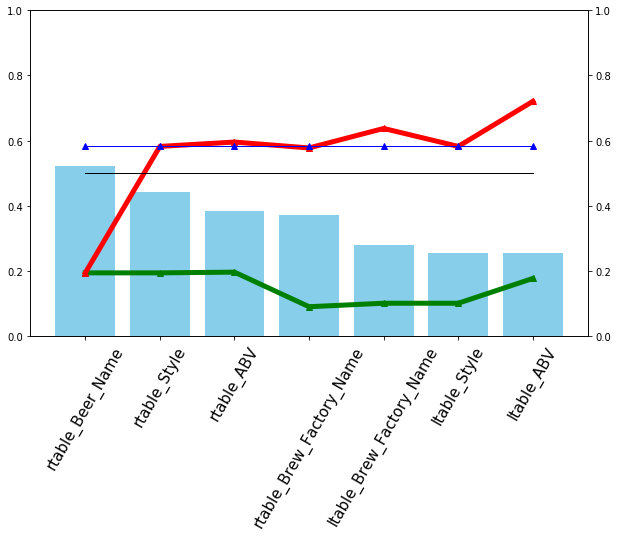

0.016588930040597916
mask
[0.034294024, 0.052896123, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893]
[0.034294024, 0.05383291, 0.13815734, 0.15127827, 0.99965954, 0.9999883, 0.9991948]


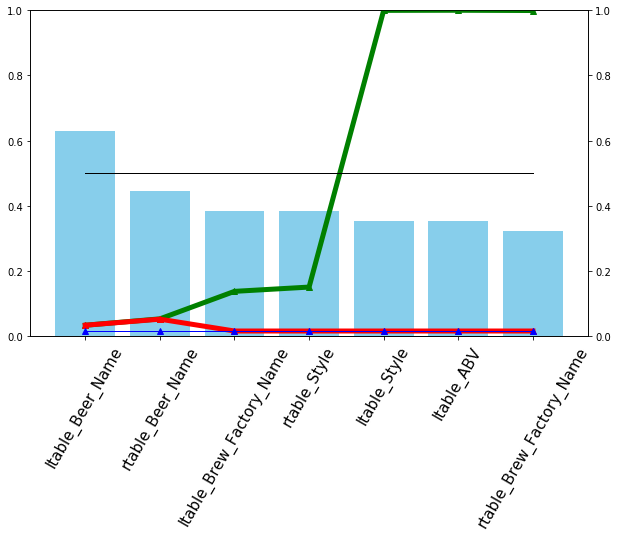

0.016588930040597916
copy
[0.01658893, 0.9711483, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.023515701]
[0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893]


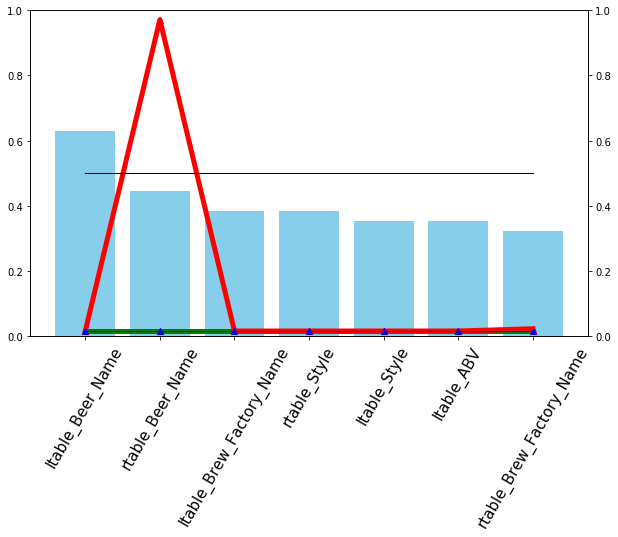

0.016588930040597916
rand
[0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893]
[0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893]


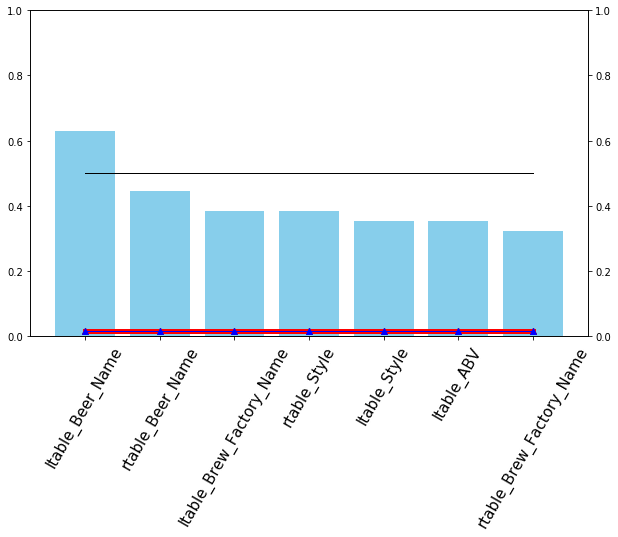

0.01998080313205719
mask
[0.42403457, 0.0267854, 0.01658893, 0.018602736, 0.3938582, 0.020151898, 0.026697436]
[0.42403457, 0.47800586, 0.103398345, 0.9998667, 0.99999857, 0.99999154, 0.99918145]


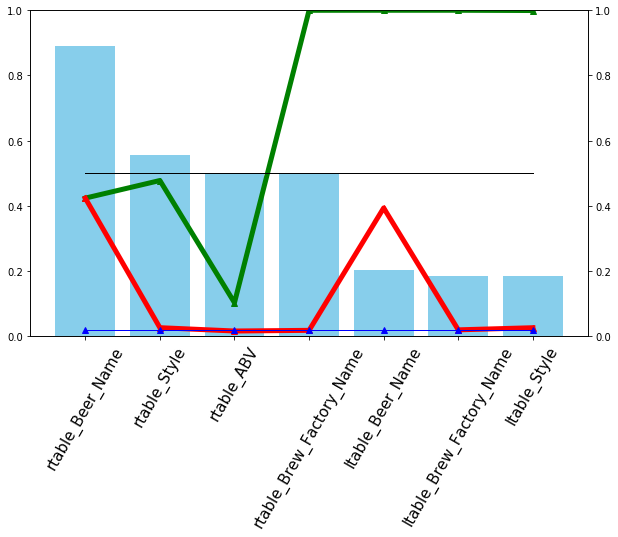

0.01998080313205719
copy
[0.9187911, 0.017707014, 0.019980803, 0.019980803, 0.39391434, 0.019980803, 0.01916942]
[0.9187911, 0.91106075, 0.91106075, 0.91106075, 0.91106075, 0.91106075, 0.91106075]


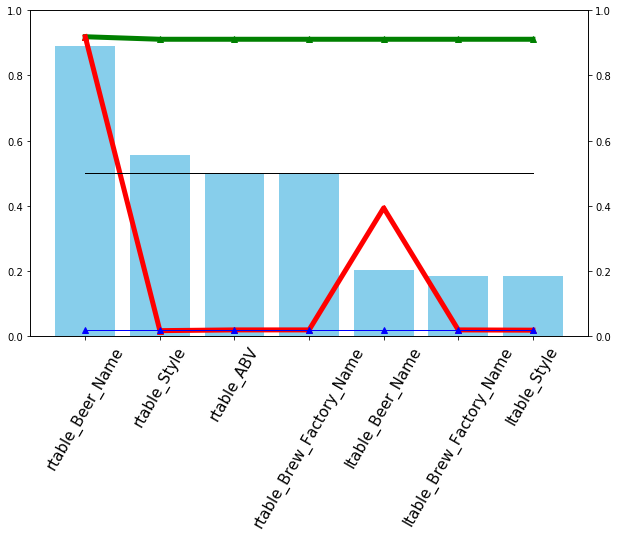

0.01998080313205719
rand
[0.77291435, 0.018737862, 0.02099373, 0.021040093, 0.02640124, 0.019696955, 0.019980803]
[0.77291435, 0.8722137, 0.86900187, 0.4996848, 0.48101848, 0.46801728, 0.46801728]


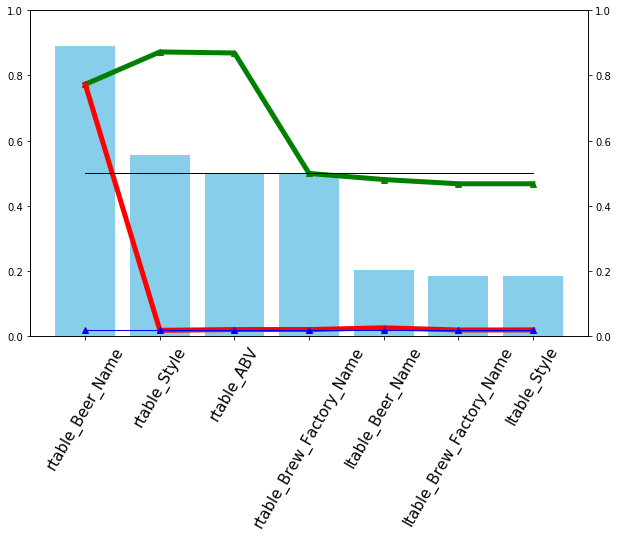

0.16183564066886902
mask
[0.01658893, 0.16026576, 0.14710416, 0.15551376, 0.01658893, 0.16639338, 0.19046676]
[0.01658893, 0.023008749, 0.9907301, 0.99812883, 0.99999917, 0.9999981, 0.99948716]


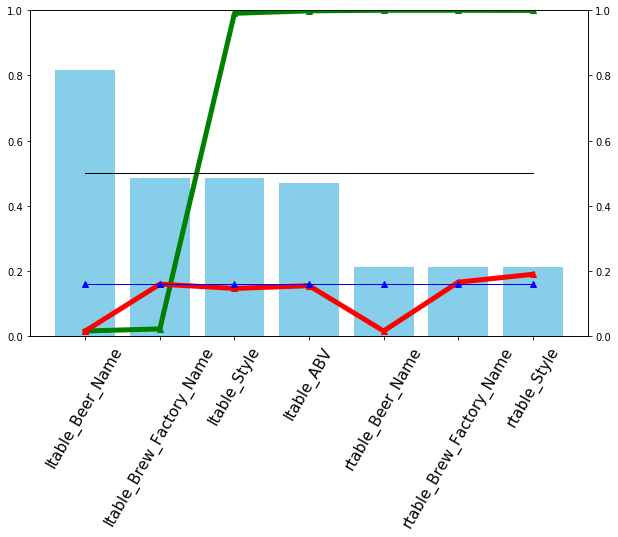

0.16183564066886902
copy
[0.058275234, 0.16588794, 0.16104665, 0.14108868, 0.35086417, 0.16262425, 0.15290676]
[0.058275234, 0.058318235, 0.062840626, 0.05332735, 0.05332735, 0.05332735, 0.05332735]


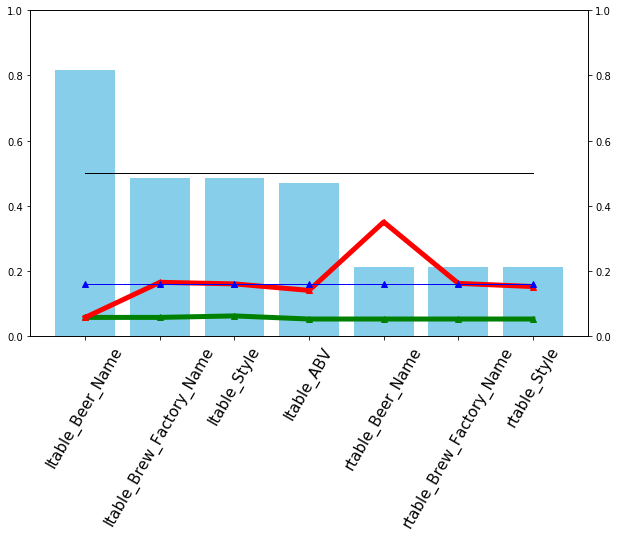

0.16183564066886902
rand
[0.01658893, 0.17514317, 0.16183564, 0.19063963, 0.355002, 0.16451743, 0.16978873]
[0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893]


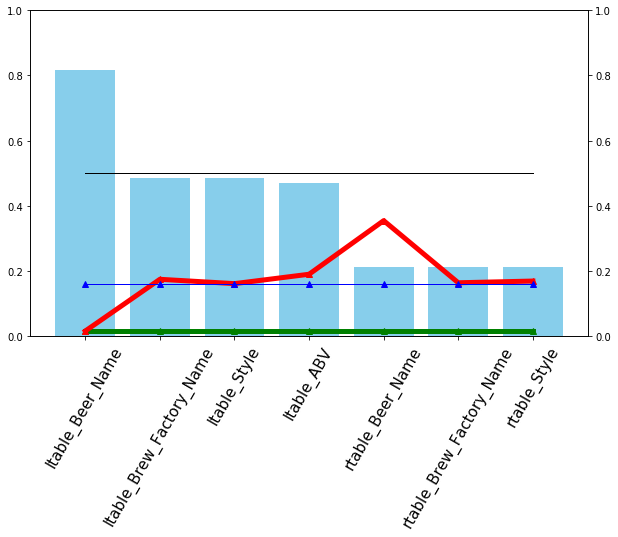

0.06117797642946243
mask
[0.01658893, 0.060234893, 0.020625712, 0.018950403, 0.32706833, 0.062281758, 0.08493451]
[0.01658893, 0.01658893, 0.01658893, 0.99739873, 0.9999995, 0.99999905, 0.9993399]


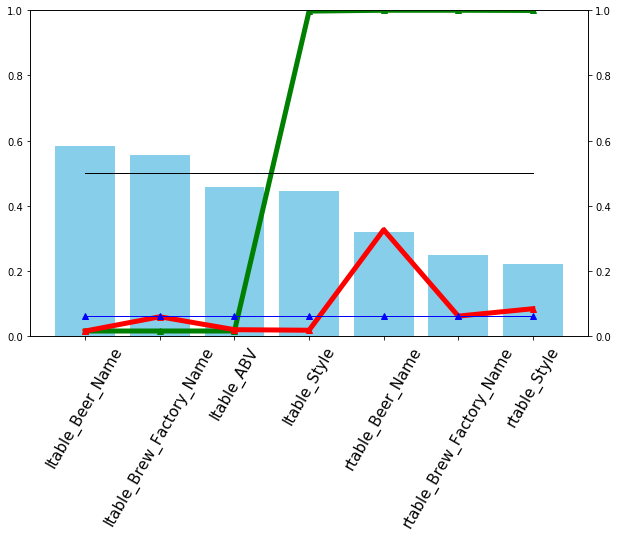

0.06117797642946243
copy
[0.4828127, 0.57417876, 0.025899215, 0.017492274, 0.64013296, 0.0500464, 0.020187587]
[0.4828127, 0.25411204, 0.2312613, 0.48054034, 0.48054034, 0.48054034, 0.48054034]


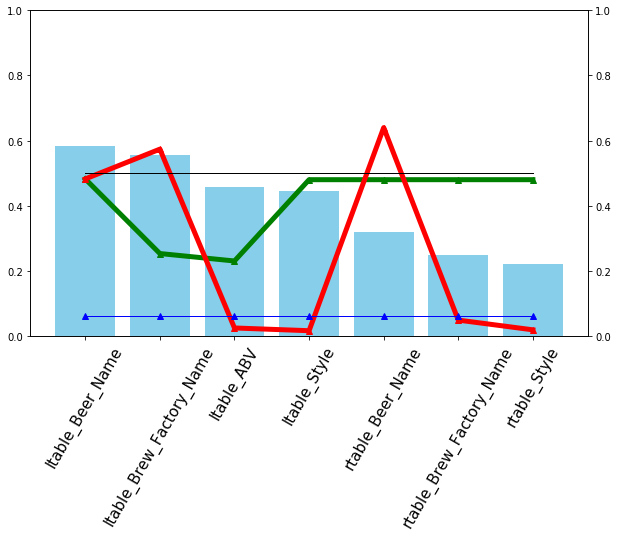

0.06117797642946243
rand
[0.01658893, 0.2106326, 0.026932968, 0.061177976, 0.037281774, 0.06065454, 0.046645045]
[0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893]


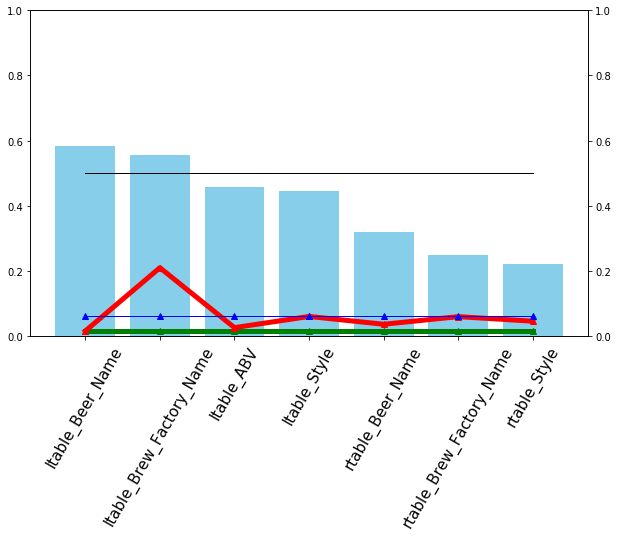

0.9985583424568176
mask
[0.0847195, 0.9997806, 0.99982005, 0.033820607, 0.99705935, 0.99784935, 0.9988199]
[0.0847195, 0.42553014, 0.9845924, 0.99986947, 0.99999297, 0.9999907, 0.99958867]


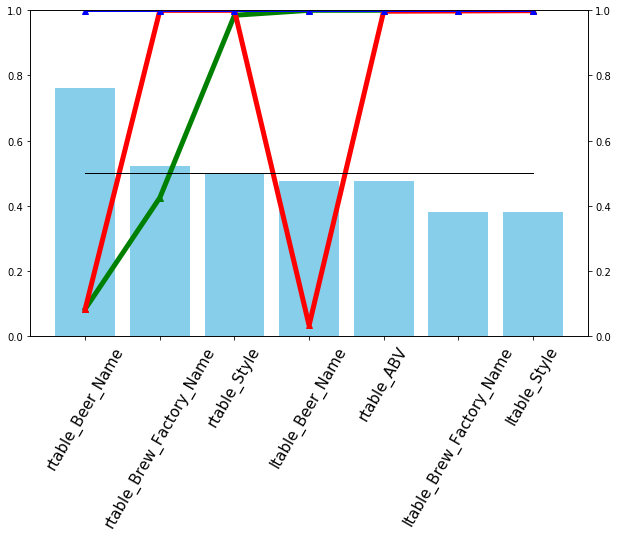

0.9985583424568176
copy
[0.99855834, 0.999887, 0.99750745, 0.99855834, 0.99855834, 0.98590183, 0.9987344]
[0.99855834, 0.999887, 0.9998561, 0.9998561, 0.9998561, 0.9998561, 0.9998561]


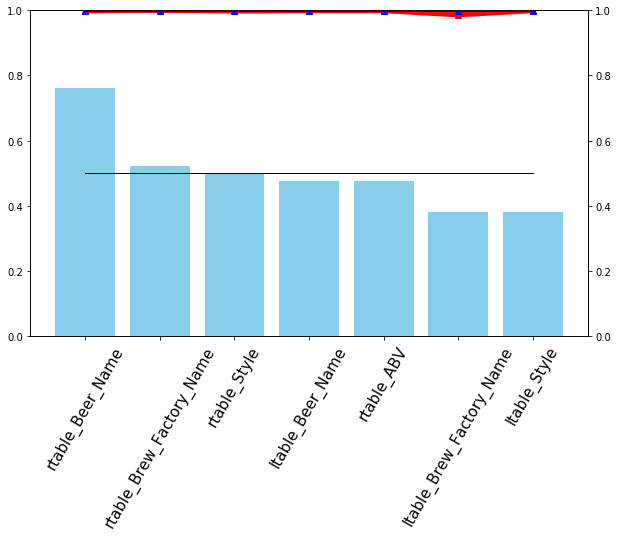

0.9985583424568176
rand
[0.67146087, 0.9772703, 0.9990262, 0.66211104, 0.99807537, 0.99411255, 0.99855834]
[0.67146087, 0.47873875, 0.5196347, 0.8458619, 0.86263615, 0.71664125, 0.71664125]


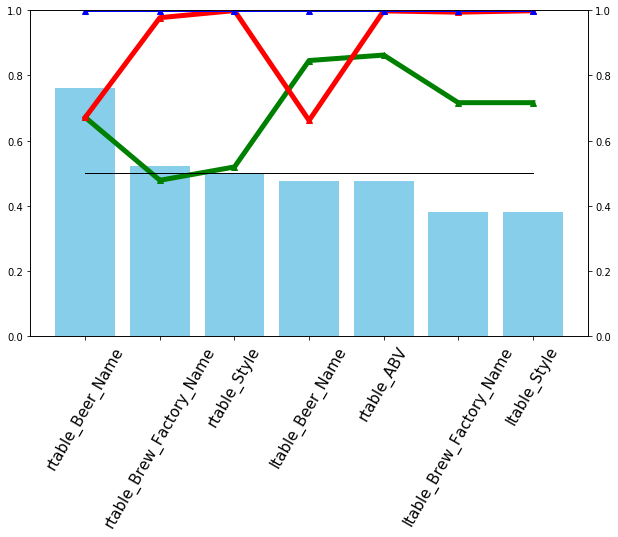

0.6941395998001099
mask
[0.094059594, 0.01658893, 0.6625261, 0.6491936, 0.6864893, 0.66260725, 0.81441206]
[0.094059594, 0.57955724, 0.23551698, 0.99990726, 0.9999957, 0.99999416, 0.9999963]


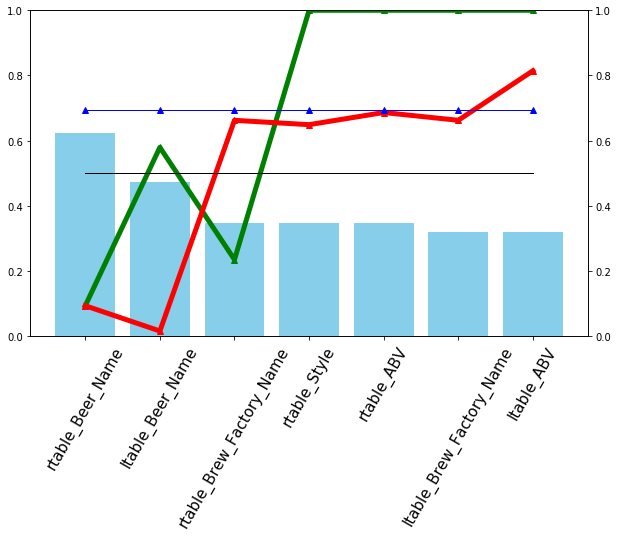

0.6941395998001099
copy
[0.97078687, 0.17117958, 0.6671456, 0.64609647, 0.612117, 0.7941296, 0.8101154]
[0.97078687, 0.97078687, 0.93407434, 0.9389795, 0.94144416, 0.94144416, 0.94144416]


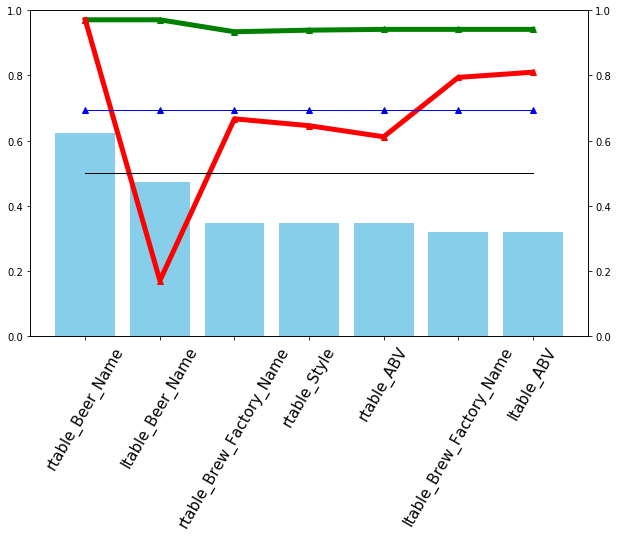

0.6941395998001099
rand
[0.49980772, 0.23163594, 0.6767155, 0.6941396, 0.6941396, 0.7093196, 0.7998476]
[0.49980772, 0.17163102, 0.16852422, 0.16852422, 0.16852422, 0.124022305, 0.19883646]


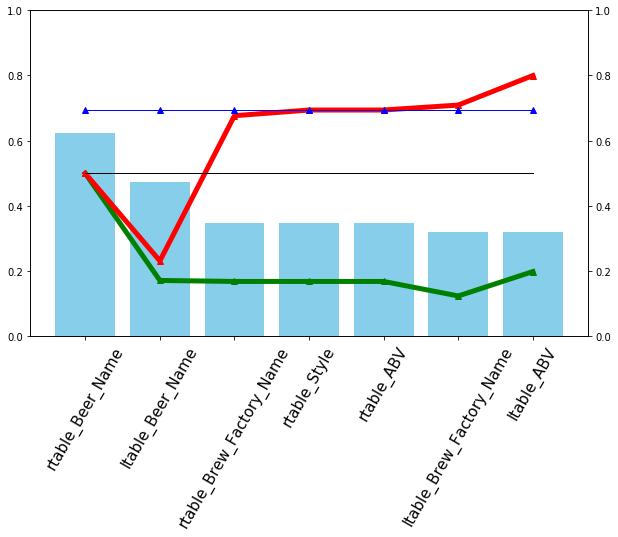

0.9789911508560181
mask
[0.04786827, 0.019734304, 0.94731766, 0.98124874, 0.9855122, 0.67213714, 0.97505176]
[0.04786827, 0.20141011, 0.08627134, 0.083179824, 0.28269947, 0.99999225, 0.99961805]


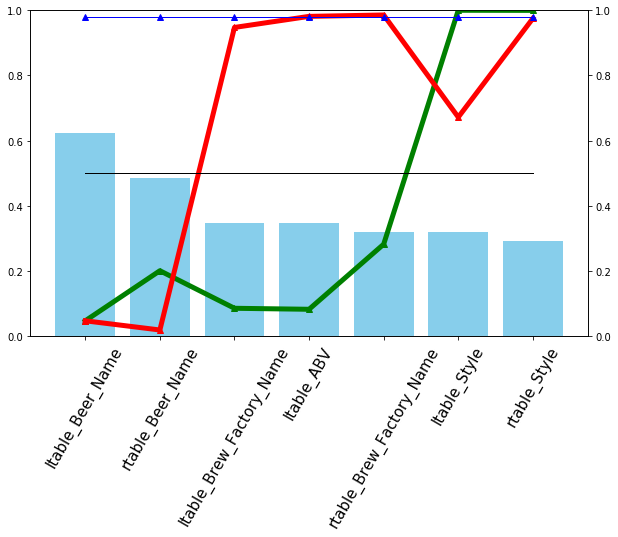

0.9789911508560181
copy
[0.44346195, 0.999997, 0.99117696, 0.97740936, 0.9561438, 0.9580338, 0.9872204]
[0.44346195, 0.44346195, 0.42194682, 0.53954345, 0.53954345, 0.42097005, 0.42097005]


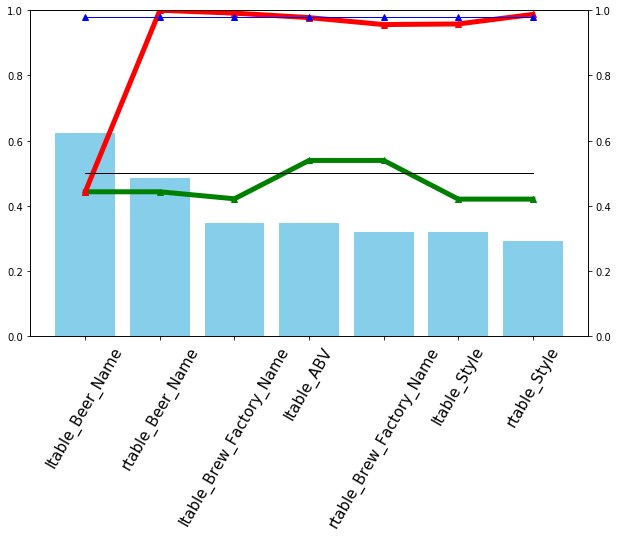

0.9789911508560181
rand
[0.10470792, 0.01658893, 0.97693866, 0.9708575, 0.9858612, 0.97899115, 0.98333526]
[0.10470792, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893]


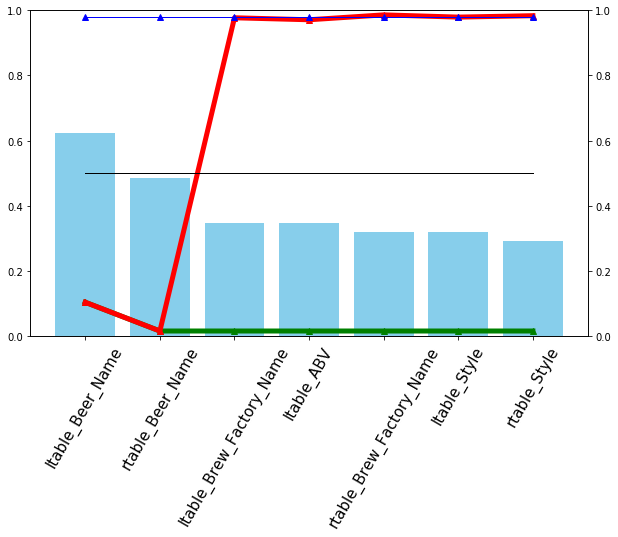

0.016588930040597916
mask
[0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893]
[0.01658893, 0.01658893, 0.02506505, 0.99969864, 0.9994862, 0.99906117, 0.99999857]


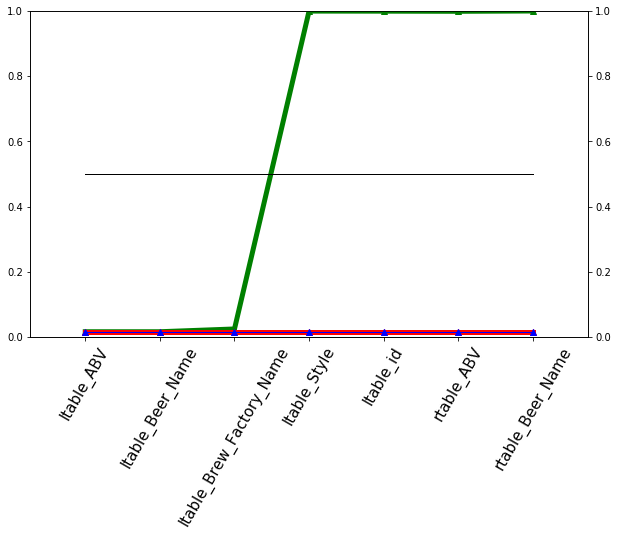

0.016588930040597916
copy
[0.01658893, 0.13565099, 0.01658893, 0.01658893, 0.01658893, 0.38168356, 0.01658893]
[0.01658893, 0.16378474, 0.15215059, 0.05451801, 0.05451801, 0.05451801, 0.05451801]


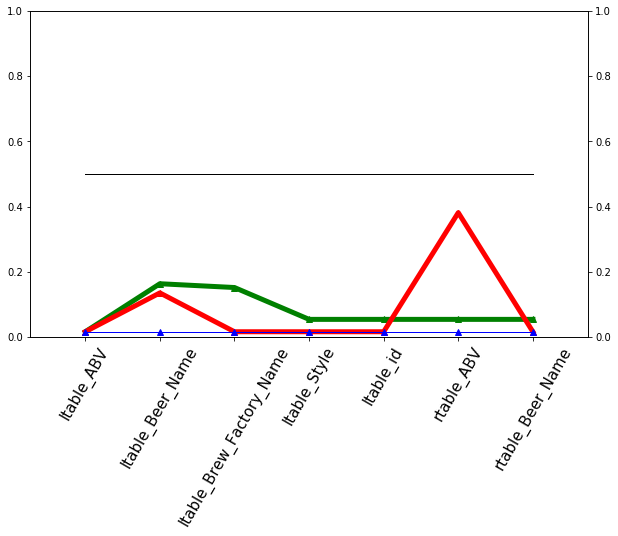

0.016588930040597916
rand
[0.01658893, 0.6666777, 0.01658893, 0.01658893, 0.01658893, 0.40270776, 0.01658893]
[0.01658893, 0.6885245, 0.8238009, 0.8238009, 0.68326676, 0.671902, 0.46849334]


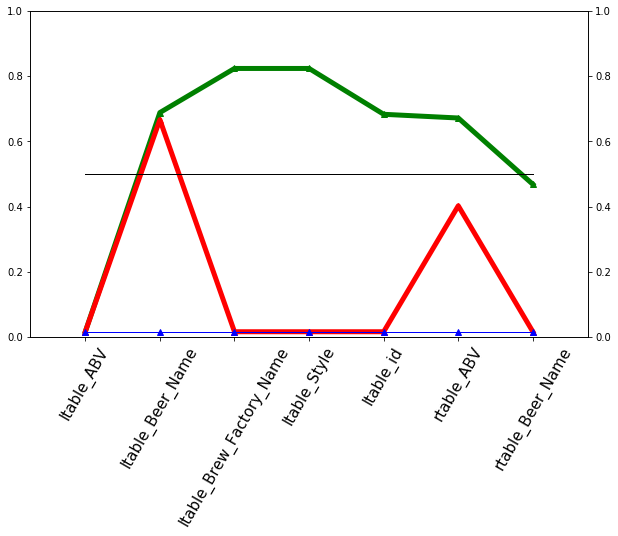

0.016588930040597916
mask
[0.01658893, 0.088095576, 0.01658893, 0.01658893, 0.01658893, 0.8929399, 0.01658893]
[0.01658893, 0.07107986, 0.01658893, 0.9983039, 0.99843985, 0.99999976, 0.9999956]


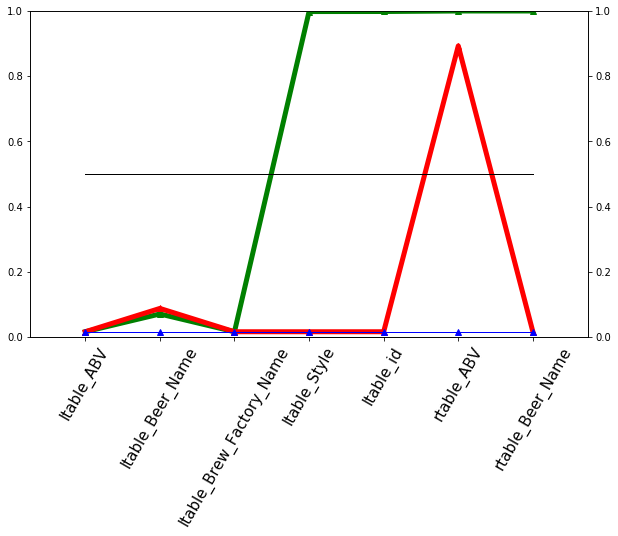

0.016588930040597916
copy
[0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.9999497, 0.01658893]
[0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893]


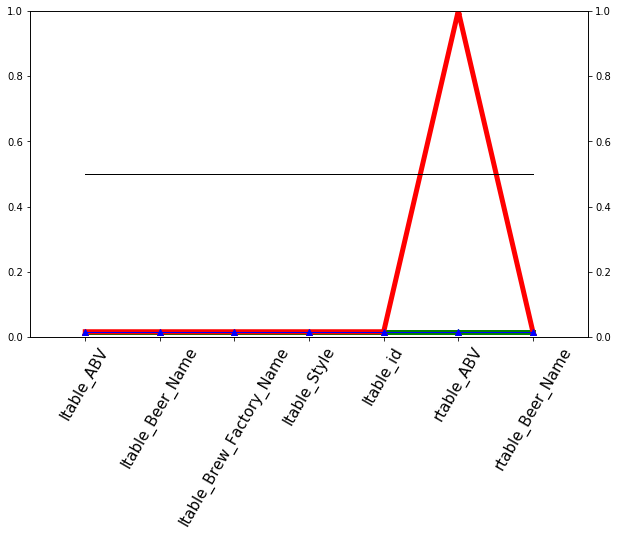

0.016588930040597916
rand
[0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893]
[0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893]


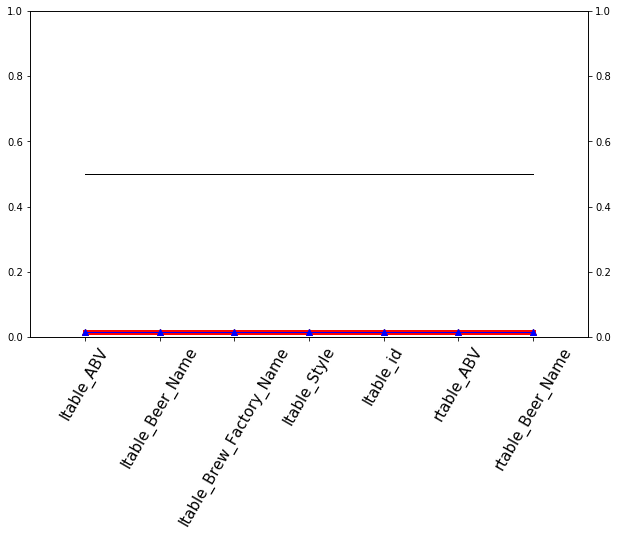

0.5825655460357666
mask
[0.4581605, 0.040085513, 0.5334703, 0.39849988, 0.56617254, 0.8860878, 0.63825387]
[0.4581605, 0.01658893, 0.01658893, 0.06604425, 0.05759571, 0.23643208, 0.99999917]


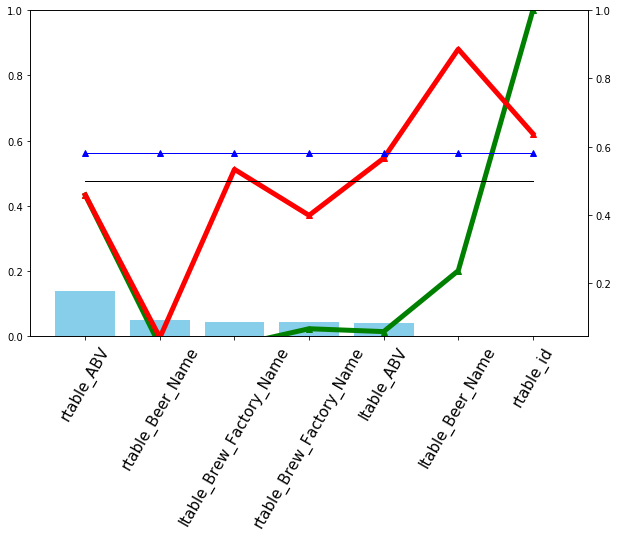

0.5825655460357666
copy
[0.58256555, 0.70894027, 0.46503752, 0.51080585, 0.58256555, 0.9991441, 0.6113004]
[0.58256555, 0.70894027, 0.5479699, 0.5479699, 0.5479699, 0.5479699, 0.55391973]


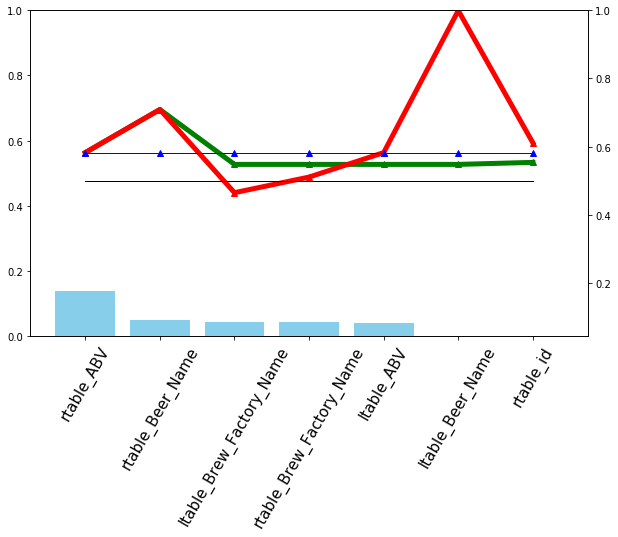

0.5825655460357666
rand
[0.5865049, 0.01658893, 0.5420197, 0.57075113, 0.5504014, 0.14391176, 0.58256555]
[0.5865049, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893]


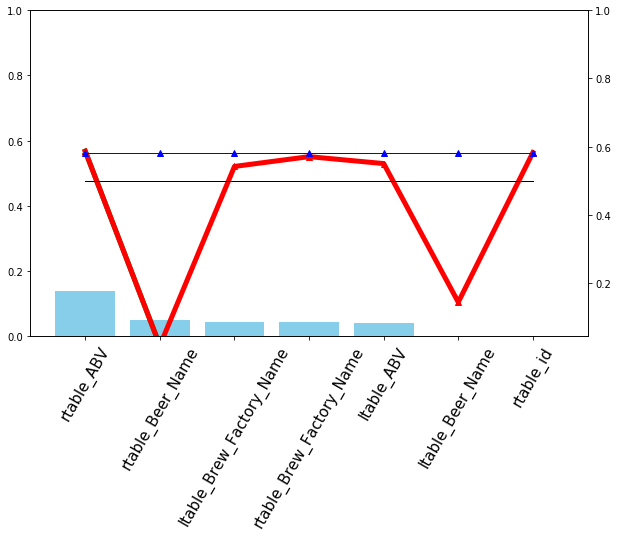

0.016588930040597916
mask
[0.01658893, 0.01658893, 0.034294024, 0.052896123, 0.01658893, 0.01658893, 0.01658893]
[0.01658893, 0.01658893, 0.01658893, 0.0824888, 0.06474534, 0.9988192, 0.999653]


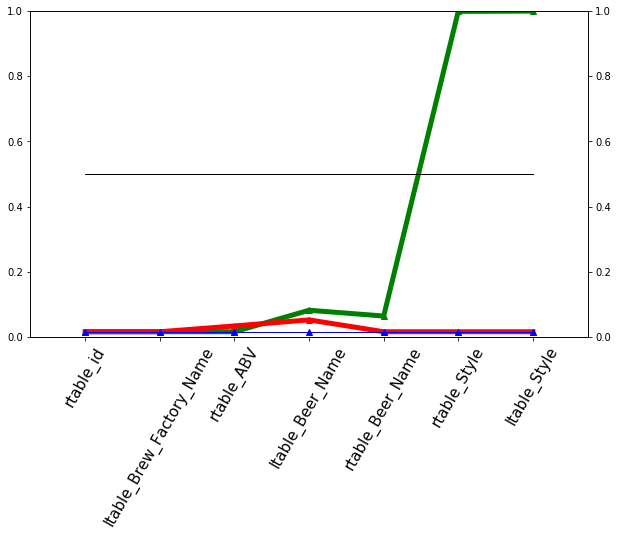

0.016588930040597916
copy
[0.01658893, 0.01658893, 0.01658893, 0.9711483, 0.01658893, 0.01658893, 0.023515701]
[0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893]


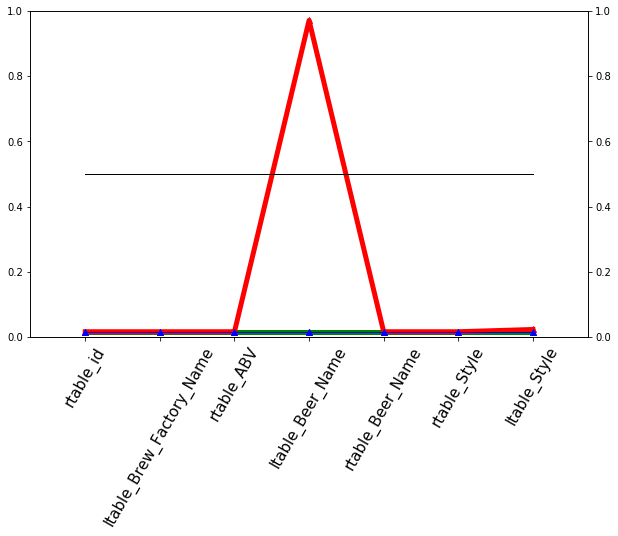

0.016588930040597916
rand
[0.01658893, 0.01658893, 0.01658893, 0.112604514, 0.01658893, 0.01658893, 0.01658893]
[0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893]


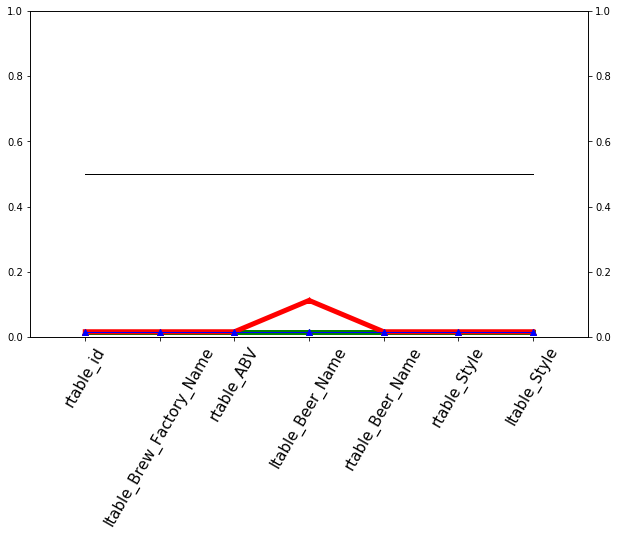

0.01998080313205719
mask
[0.01658893, 0.020855129, 0.3938582, 0.020151898, 0.026697436, 0.42403457, 0.0267854]
[0.01658893, 0.01658893, 0.28099513, 0.12033044, 0.99999857, 0.9999989, 0.9999964]


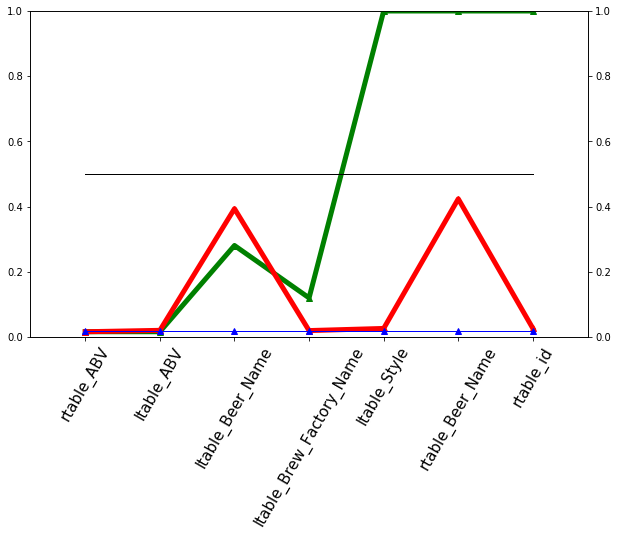

0.01998080313205719
copy
[0.019980803, 0.019980803, 0.39391434, 0.019980803, 0.01916942, 0.9187911, 0.017707014]
[0.019980803, 0.019980803, 0.39391434, 0.39391434, 0.3870529, 0.3870529, 0.3870529]


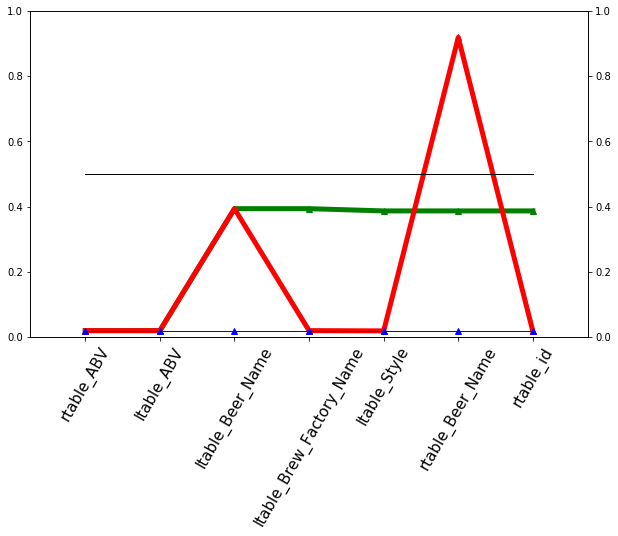

0.01998080313205719
rand
[0.01658893, 0.017122956, 0.01658893, 0.019439798, 0.019980803, 0.37521994, 0.018737862]
[0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893]


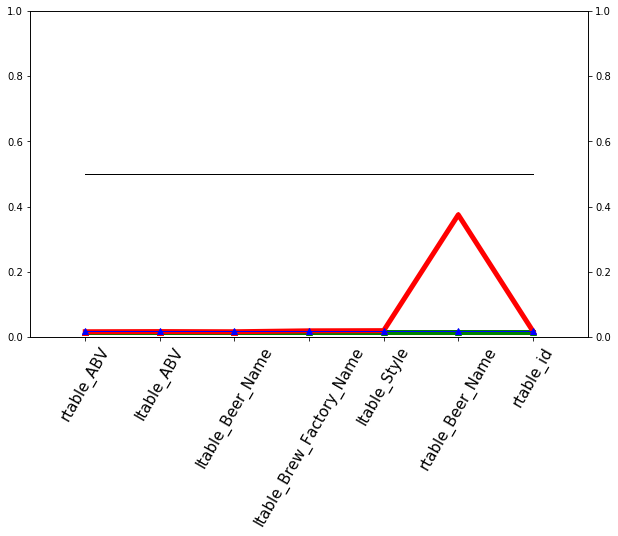

0.16183564066886902
mask
[0.01658893, 0.19046676, 0.01658893, 0.14710416, 0.15551376, 0.16026576, 0.16639338]
[0.01658893, 0.01658893, 0.25909728, 0.26390642, 0.122321256, 0.9999995, 0.99948716]


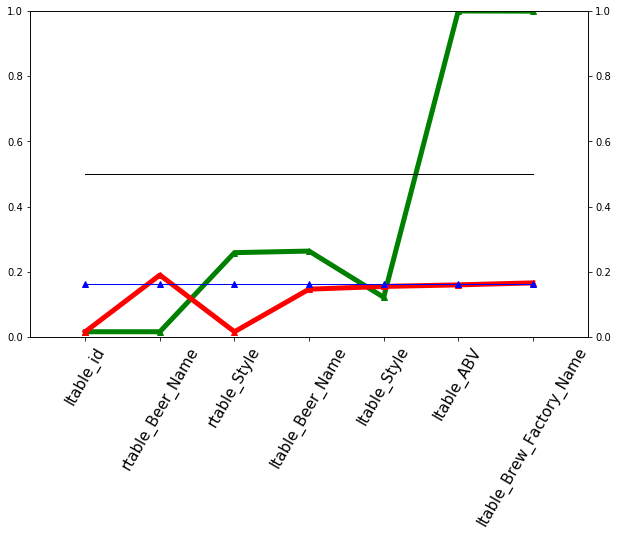

0.16183564066886902
copy
[0.35086417, 0.15290676, 0.058275234, 0.16104665, 0.14108868, 0.16588794, 0.16262425]
[0.35086417, 0.33283386, 0.33283386, 0.33283386, 0.29711178, 0.2868367, 0.2868367]


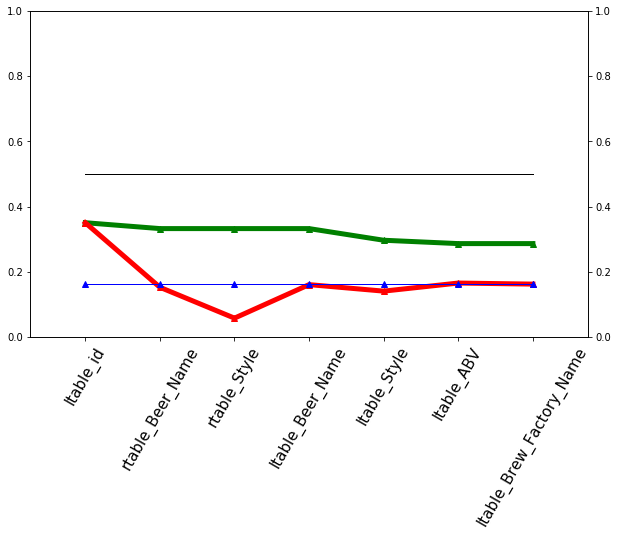

0.16183564066886902
rand
[0.01658893, 0.16978873, 0.01818063, 0.16183564, 0.19667356, 0.17553416, 0.15858097]
[0.01658893, 0.01658893, 0.30428818, 0.30428818, 0.34629664, 0.21757722, 0.14436257]


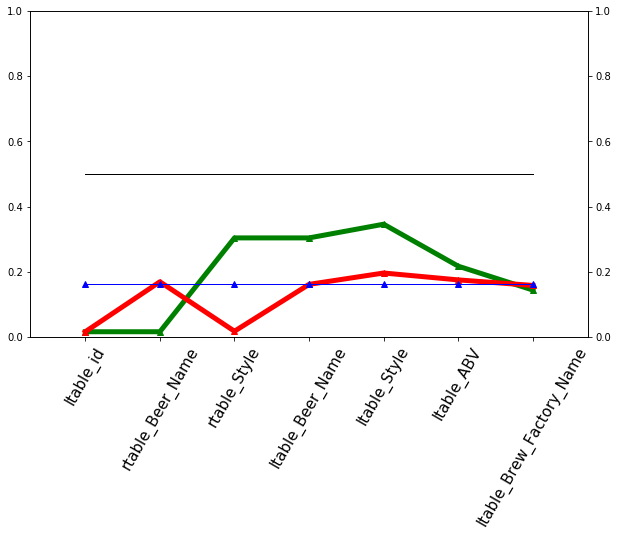

0.06117797642946243
mask
[0.041148596, 0.01658893, 0.062281758, 0.018950403, 0.060234893, 0.32706833, 0.020625712]
[0.041148596, 0.01658893, 0.01658893, 0.01658893, 0.9828751, 0.9999474, 0.99999917]


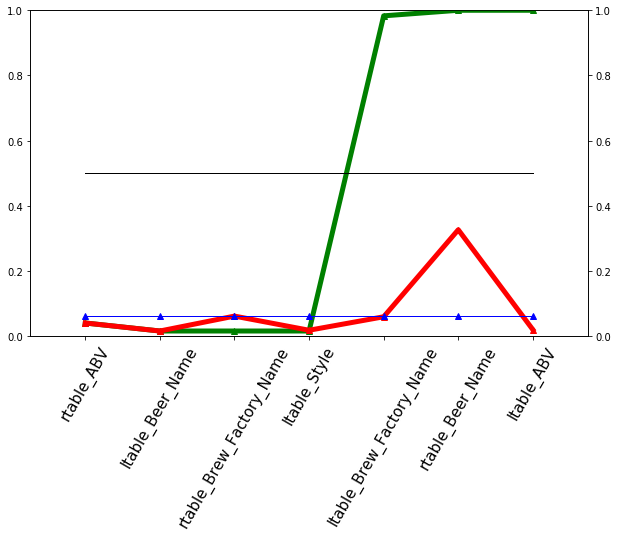

0.06117797642946243
copy
[0.06701698, 0.4828127, 0.0500464, 0.017492274, 0.57417876, 0.64013296, 0.025899215]
[0.06701698, 0.5053649, 0.5302193, 0.4898056, 0.4898056, 0.4898056, 0.4898056]


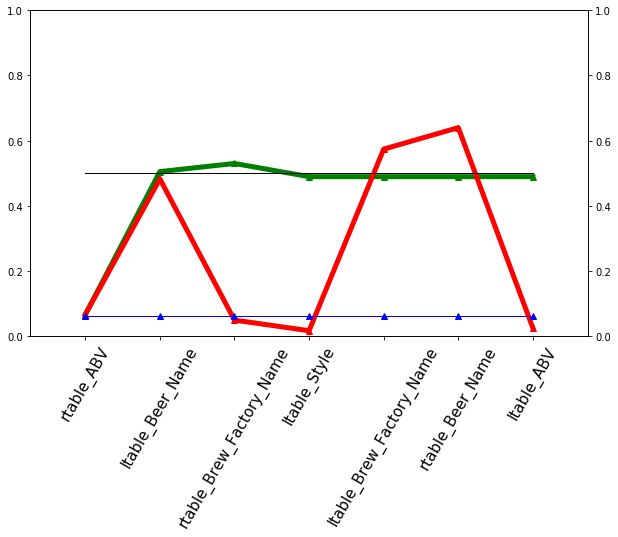

0.06117797642946243
rand
[0.033892572, 0.01658893, 0.01658893, 0.061177976, 0.26231456, 0.058026403, 0.061777353]
[0.033892572, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893]


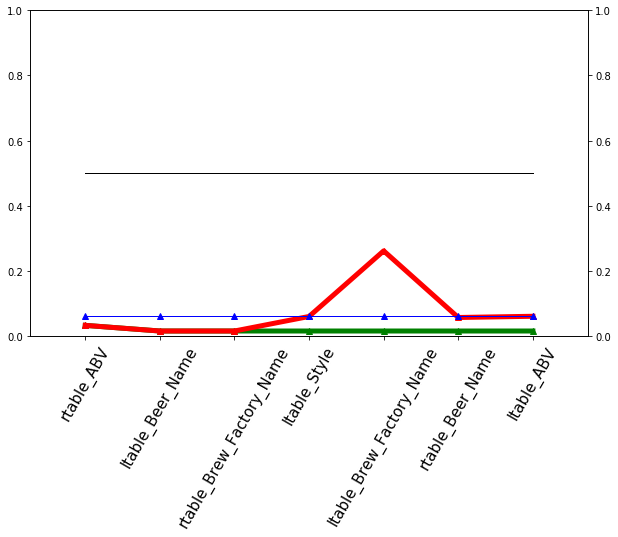

0.9985583424568176
mask
[0.0847195, 0.033820607, 0.9988199, 0.9997806, 0.99784935, 0.99982005]
[0.0847195, 0.13848595, 0.14874713, 0.2570173, 0.9999323, 0.9997814, 0.9997814]


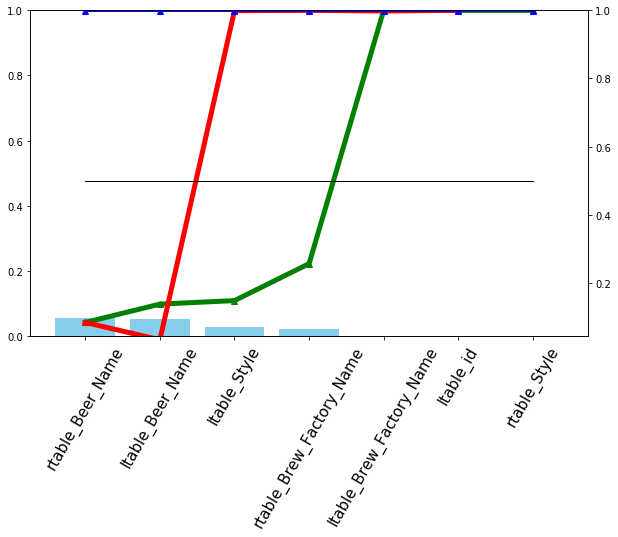

0.9985583424568176
copy
[0.99855834, 0.99855834, 0.9987344, 0.999887, 0.98590183, 0.99750745]
[0.99855834, 0.99855834, 0.9987344, 0.9999044, 0.9999044, 0.9999044, 0.9999044]


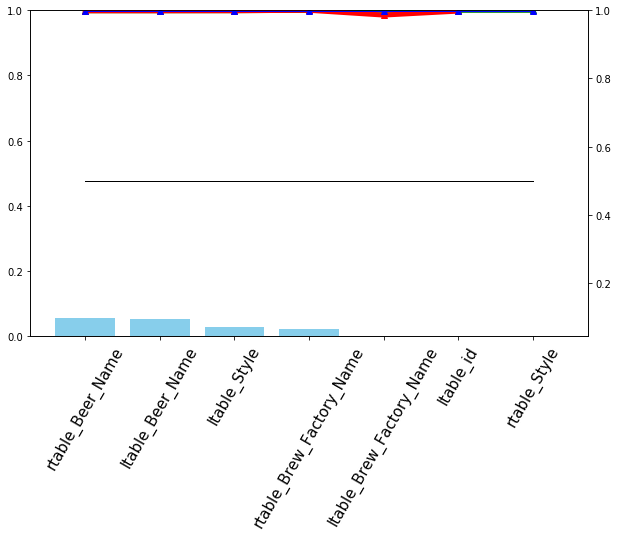

0.9985583424568176
rand
[0.9551033, 0.028963888, 0.99855834, 0.9996481, 0.9946997, 0.99855834]
[0.9551033, 0.018516764, 0.018516764, 0.01703444, 0.01929835, 0.01929835, 0.01929835]


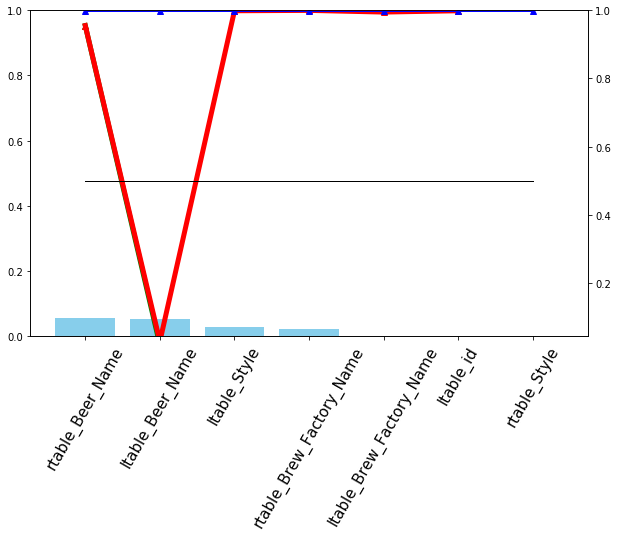

0.6941395998001099
mask
[0.81441206, 0.6625261, 0.5187395, 0.01658893, 0.66260725, 0.094059594, 0.6491936]
[0.81441206, 0.7954013, 0.39455265, 0.01658893, 0.99766636, 0.99999726, 0.9990742]


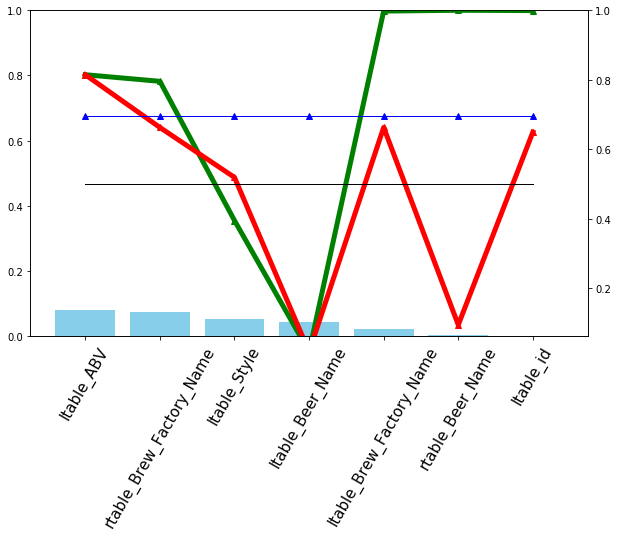

0.6941395998001099
copy
[0.8101154, 0.6671456, 0.70272803, 0.17117958, 0.7941296, 0.97078687, 0.64609647]
[0.8101154, 0.79149014, 0.7890488, 0.26810756, 0.26810756, 0.26810756, 0.26810756]


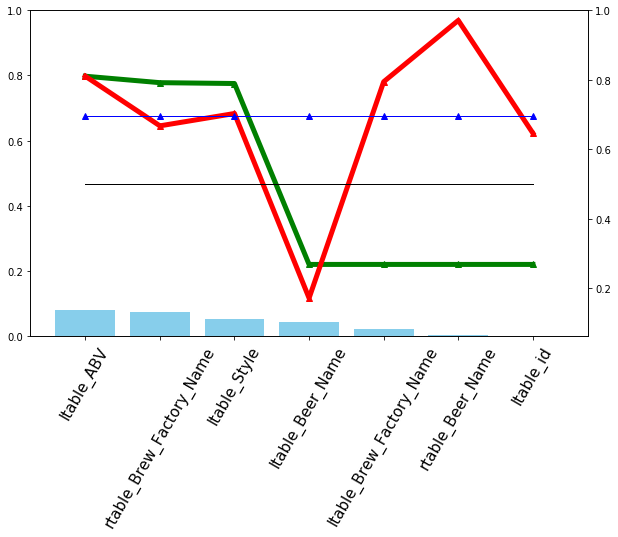

0.6941395998001099
rand
[0.7808293, 0.6783903, 0.6941396, 0.01658893, 0.701907, 0.01658893, 0.68431896]
[0.7808293, 0.77273214, 0.77273214, 0.01658893, 0.01658893, 0.01658893, 0.01658893]


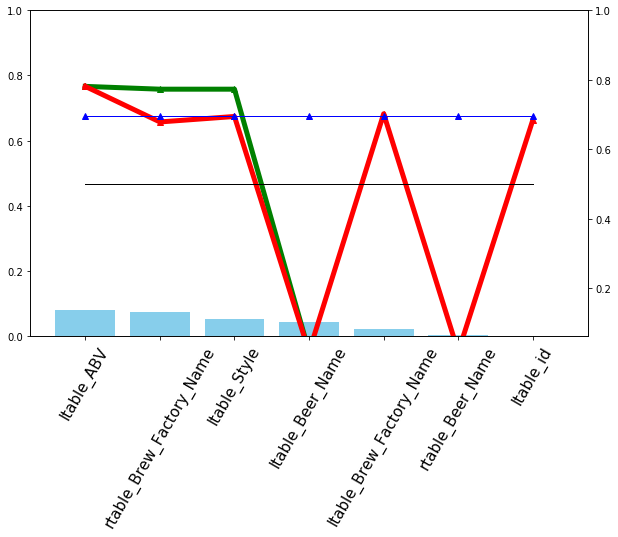

0.9789911508560181
mask
[0.04786827, 0.9855122, 0.019734304, 0.67213714, 0.94731766]
[0.04786827, 0.061109588, 0.1383501, 0.119457915, 0.9997646, 0.9997646, 0.9997646]
0.9789911508560181
copy
[0.44346195, 0.9561438, 0.999997, 0.9580338, 0.99117696]
[0.44346195, 0.9075864, 0.9075864, 0.91970277, 0.91970277, 0.91970277, 0.91970277]
0.9789911508560181
rand
[0.01658893, 0.9784984, 0.9727985, 0.97899115, 0.93695825]
[0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893]
0.016588930040597916
mask
[0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893]
[0.01658893, 0.01658893, 0.9948726, 0.99969864, 0.99929583, 0.9999994, 0.9967392]


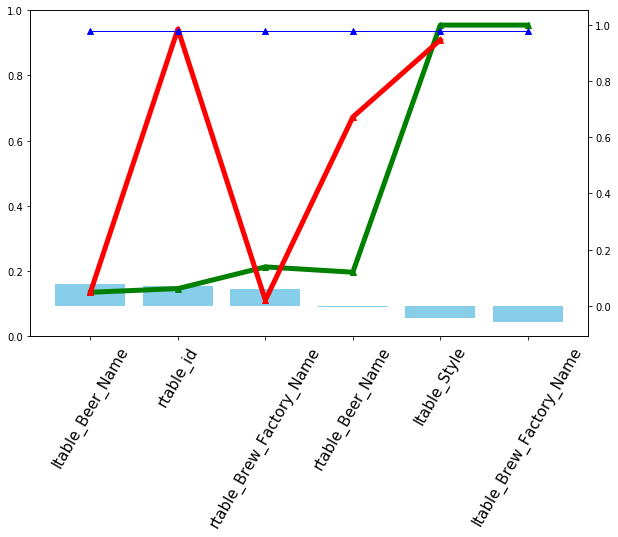

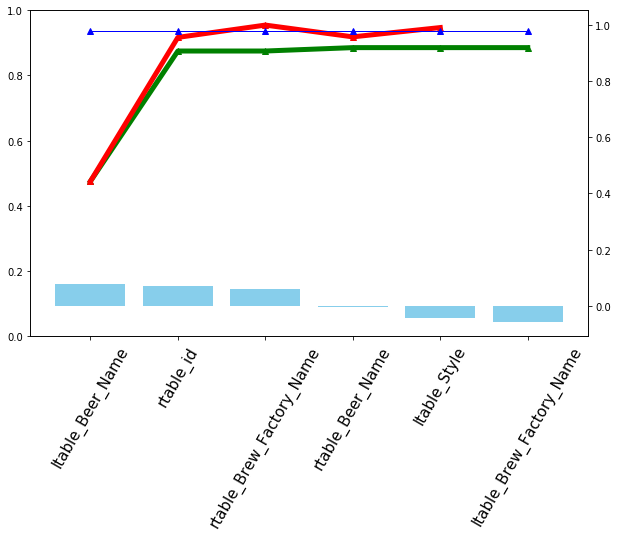

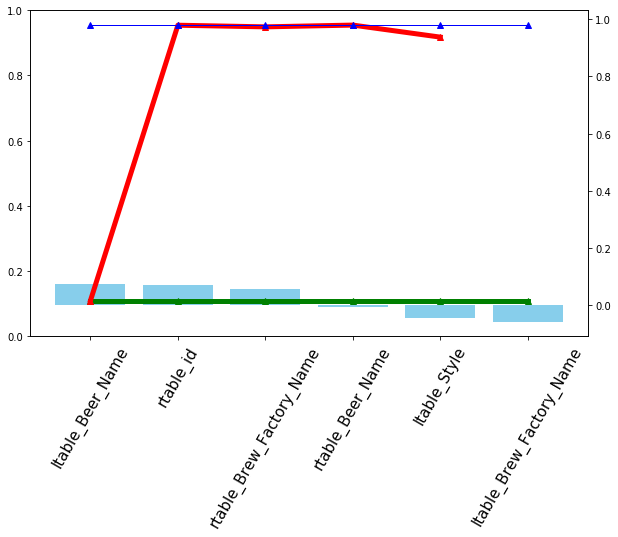

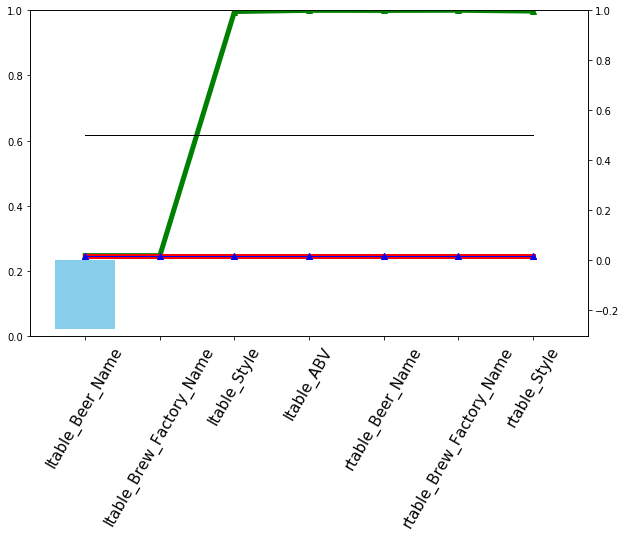

0.016588930040597916
copy
[0.13565099, 0.01658893, 0.01658893, 0.01658893, 0.38168356, 0.01658893, 0.01658893]
[0.13565099, 0.15424515, 0.01658893, 0.05451801, 0.05451801, 0.05451801, 0.05451801]


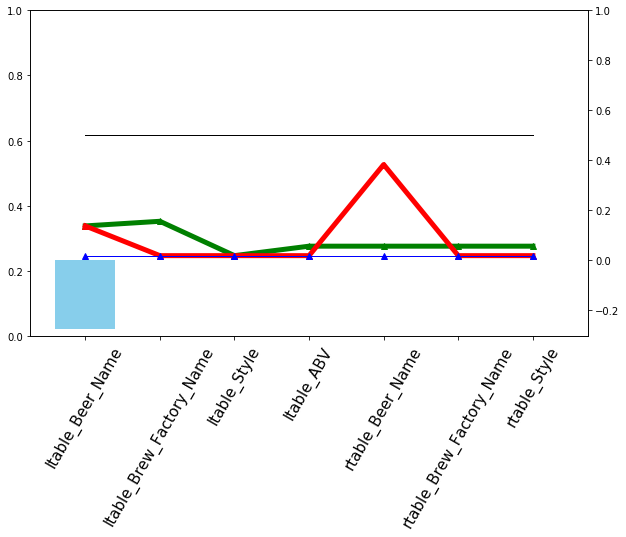

0.016588930040597916
rand
[0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.34664857, 0.01658893, 0.01658893]
[0.01658893, 0.033335947, 0.033335947, 0.037626237, 0.01658893, 0.01658893, 0.01658893]


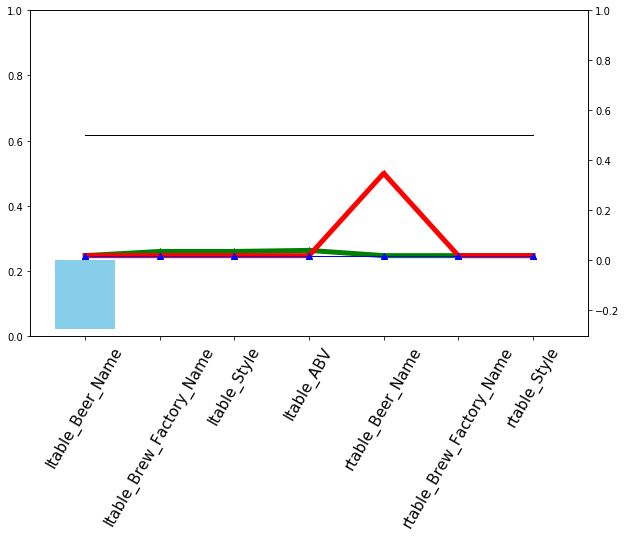

0.016588930040597916
mask
[0.01658893, 0.01658893, 0.088095576, 0.01658893, 0.01658893, 0.8929399, 0.01658893]
[0.01658893, 0.01658893, 0.01658893, 0.9724367, 0.9981792, 0.99999976, 0.99974567]


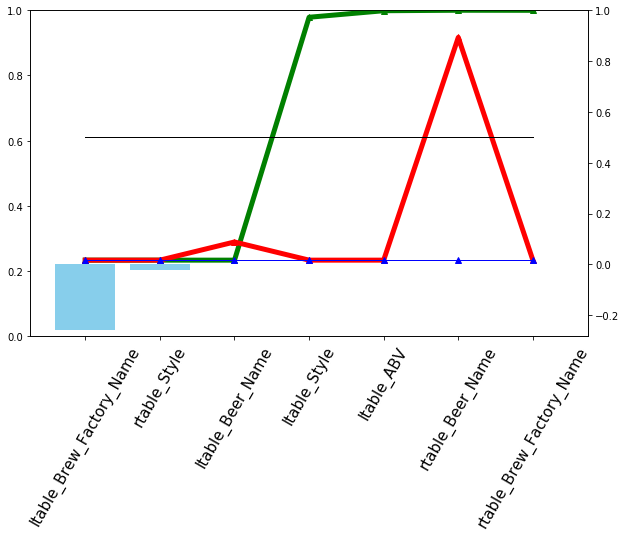

0.016588930040597916
copy
[0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.9999497, 0.01658893]
[0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893]


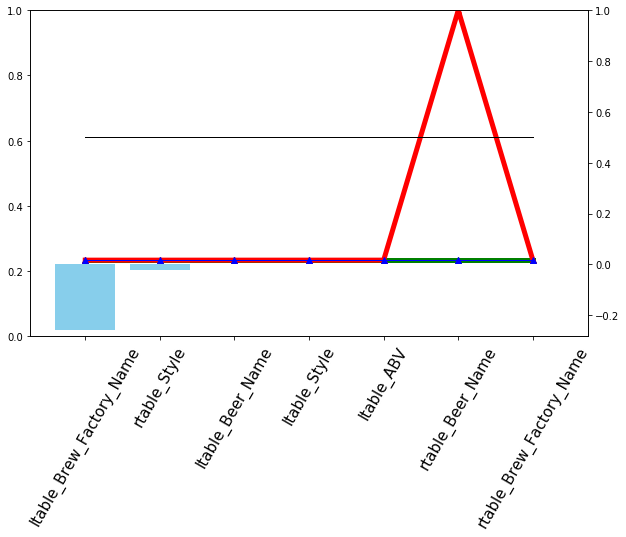

0.016588930040597916
rand
[0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893]
[0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.016769184]


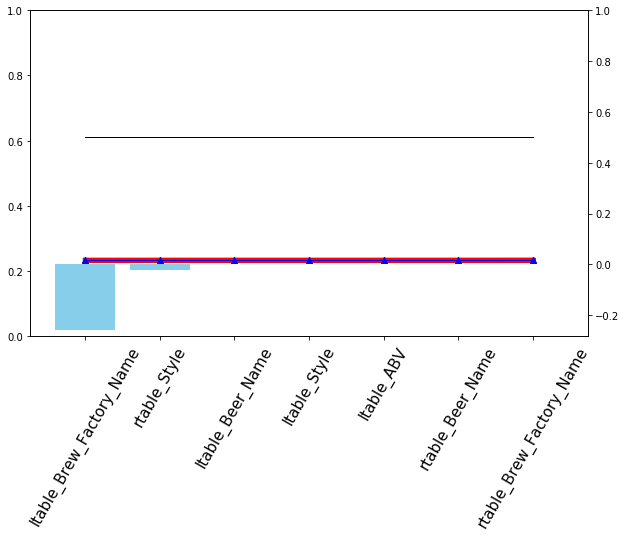

0.5825655460357666
mask
[0.5334703, 0.63825387, 0.56617254, 0.2317003, 0.4581605, 0.040085513, 0.8860878]
[0.5334703, 0.49537888, 0.5953576, 0.2156463, 0.22734568, 0.01658893, 0.99999964]


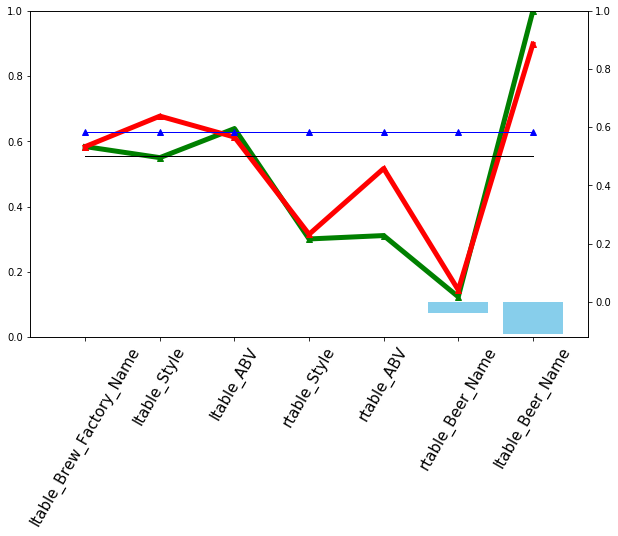

0.5825655460357666
copy
[0.46503752, 0.6113004, 0.58256555, 0.6319091, 0.58256555, 0.70894027, 0.9991441]
[0.46503752, 0.4769923, 0.4769923, 0.4769923, 0.4769923, 0.55391973, 0.55391973]


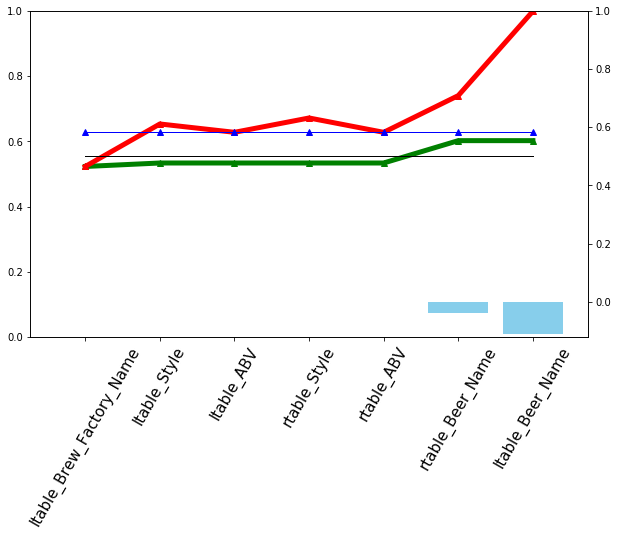

0.5825655460357666
rand
[0.5193187, 0.58256555, 0.615276, 0.58256555, 0.5865049, 0.3368638, 0.984874]
[0.5193187, 0.5193187, 0.6006862, 0.6006862, 0.6031365, 0.3503866, 0.11471417]


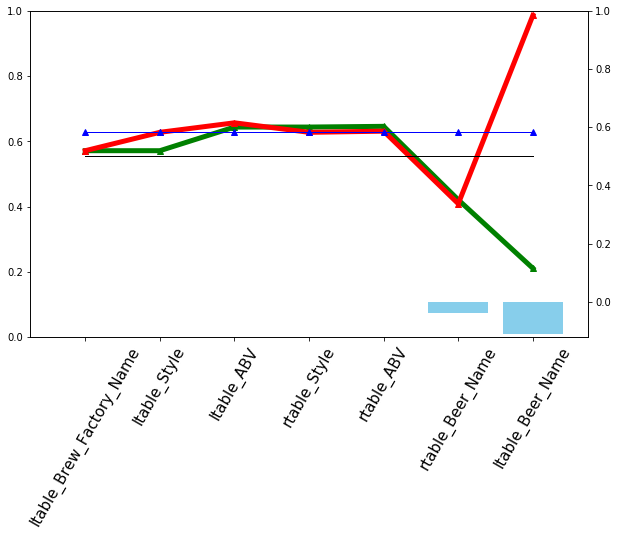

0.016588930040597916
mask
[0.01658893, 0.01658893, 0.034294024, 0.01658893, 0.01658893, 0.01658893, 0.052896123]
[0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.94192773, 0.99788636, 0.9999956]


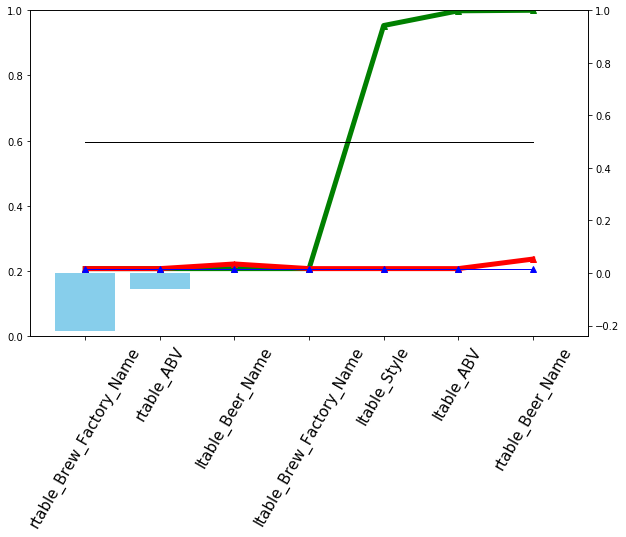

0.016588930040597916
copy
[0.023515701, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.9711483]
[0.023515701, 0.017969912, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893]


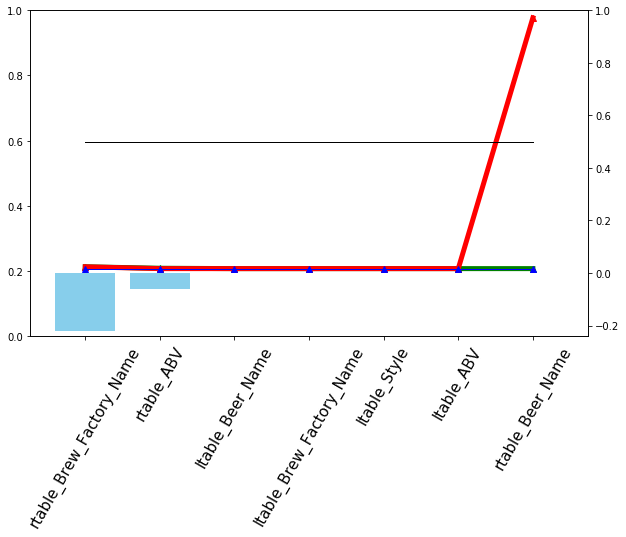

0.016588930040597916
rand
[0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893]
[0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893]


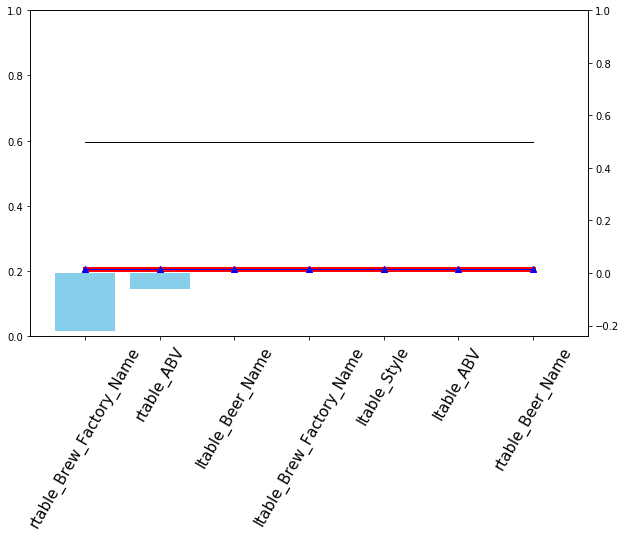

0.01998080313205719
mask
[0.020855129, 0.3938582, 0.026697436, 0.018602736, 0.0267854, 0.01658893, 0.42403457]
[0.020855129, 0.37354946, 0.35231736, 0.34617862, 0.374523, 0.20385078, 0.9999964]


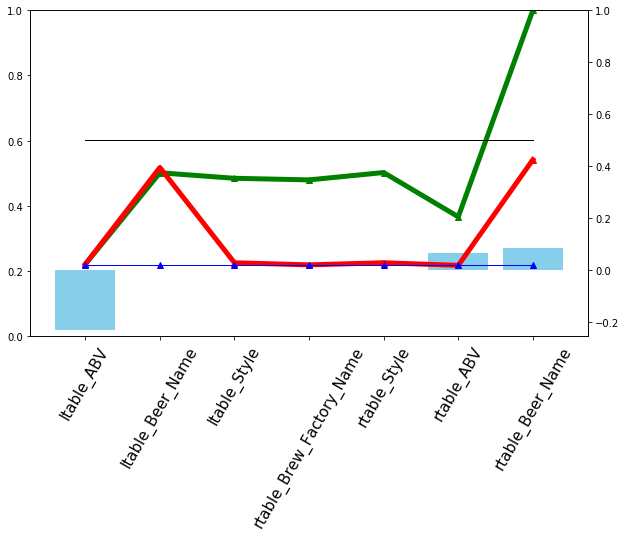

0.01998080313205719
copy
[0.019980803, 0.39391434, 0.01916942, 0.019980803, 0.017707014, 0.019980803, 0.9187911]
[0.019980803, 0.39391434, 0.3870529, 0.3870529, 0.3870529, 0.3870529, 0.3870529]


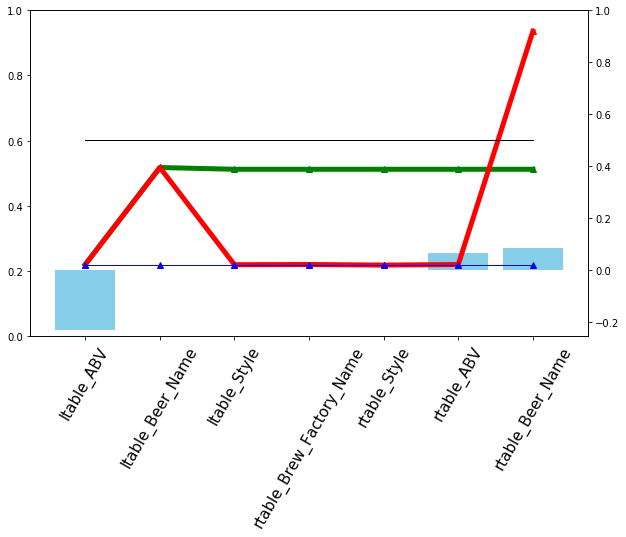

0.01998080313205719
rand
[0.017693045, 0.5042909, 0.019980803, 0.022217963, 0.01949791, 0.019751, 0.94498837]
[0.017693045, 0.46882042, 0.46882042, 0.48701775, 0.48973247, 0.4772998, 0.01658893]


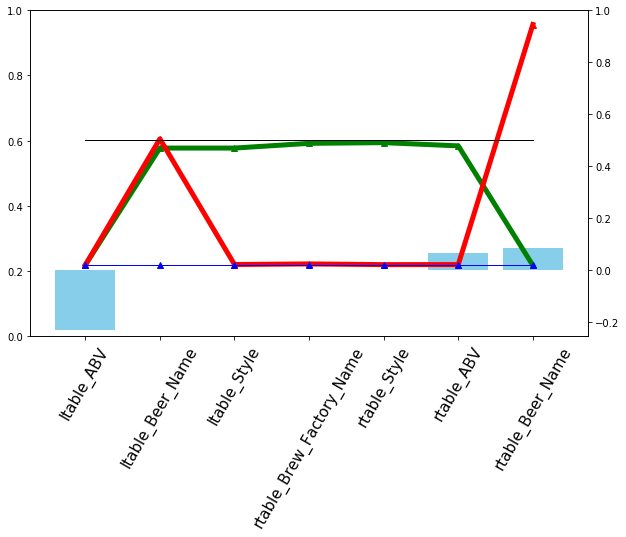

0.16183564066886902
mask
[0.15316817, 0.01658893, 0.16026576, 0.14710416, 0.15551376, 0.01658893, 0.16639338]
[0.15316817, 0.01658893, 0.02209213, 0.9905832, 0.9987527, 0.9999994, 0.99999917]


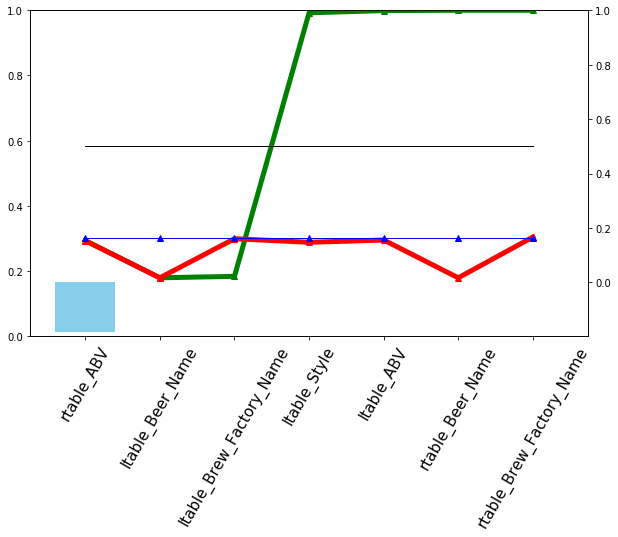

0.16183564066886902
copy
[0.18636298, 0.058275234, 0.16588794, 0.16104665, 0.14108868, 0.35086417, 0.16262425]
[0.18636298, 0.06834911, 0.06841, 0.07342507, 0.07342507, 0.07342507, 0.07342507]


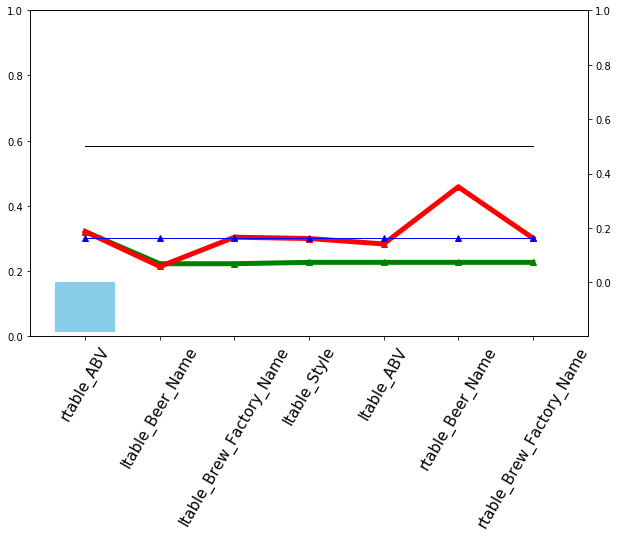

0.16183564066886902
rand
[0.22222766, 0.01658893, 0.17579581, 0.16183564, 0.21155167, 0.01658893, 0.15977304]
[0.22222766, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.023901789, 0.021814268]


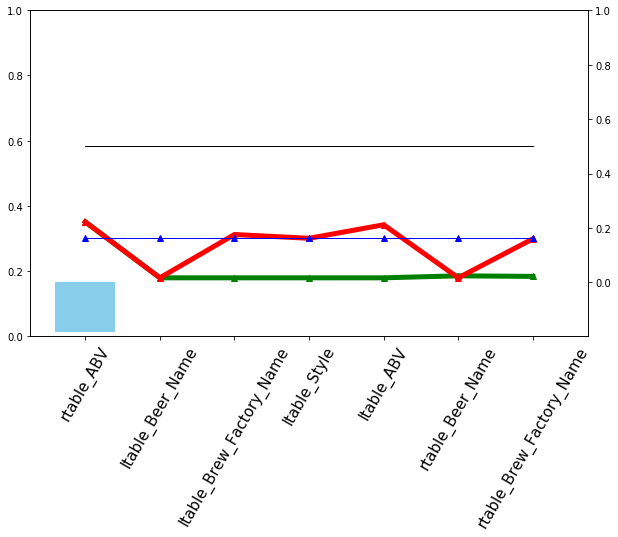

0.06117797642946243
mask
[0.020625712, 0.08493451, 0.062281758, 0.018950403, 0.01658893, 0.060234893, 0.32706833]
[0.020625712, 0.022486812, 0.020618211, 0.01658893, 0.01658893, 0.99767, 0.9993399]


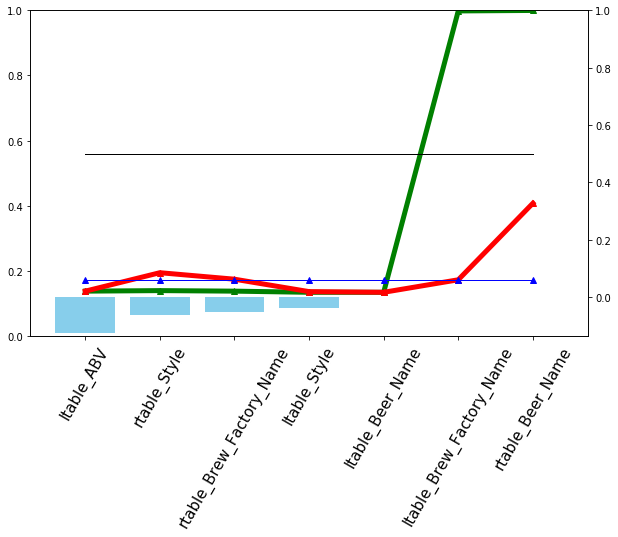

0.06117797642946243
copy
[0.025899215, 0.020187587, 0.0500464, 0.017492274, 0.4828127, 0.57417876, 0.64013296]
[0.025899215, 0.01658893, 0.01658893, 0.01658893, 0.49245992, 0.49245992, 0.49245992]


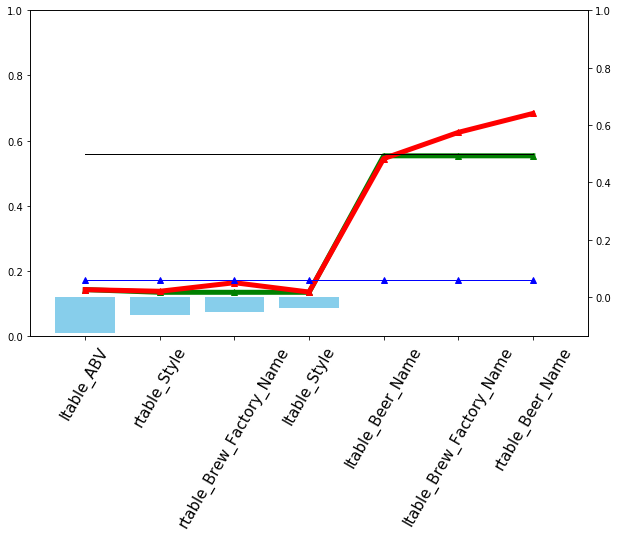

0.06117797642946243
rand
[0.019256057, 0.049814735, 0.062046997, 0.02220937, 0.01658893, 0.16268174, 0.4584173]
[0.019256057, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893]


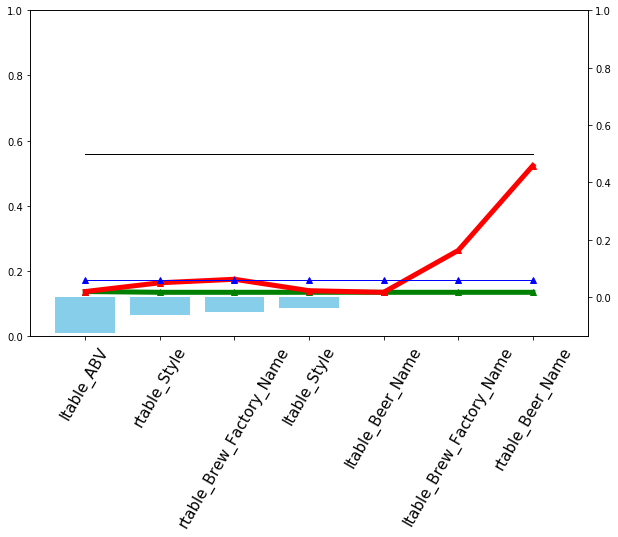

0.9985583424568176
mask
[0.9988199, 0.033820607, 0.99784935, 0.99982005, 0.99705935, 0.9984693, 0.9997806]
[0.9988199, 0.048454117, 0.9813778, 0.98295295, 0.9892113, 0.9973385, 0.99898034]


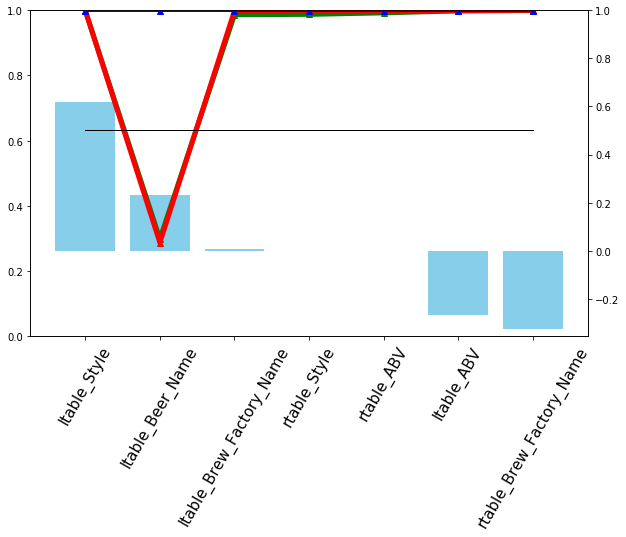

0.9985583424568176
copy
[0.9987344, 0.99855834, 0.98590183, 0.99750745, 0.99855834, 0.99855834, 0.999887]
[0.9987344, 0.9987344, 0.99299765, 0.99299765, 0.99299765, 0.99299765, 0.99299765]


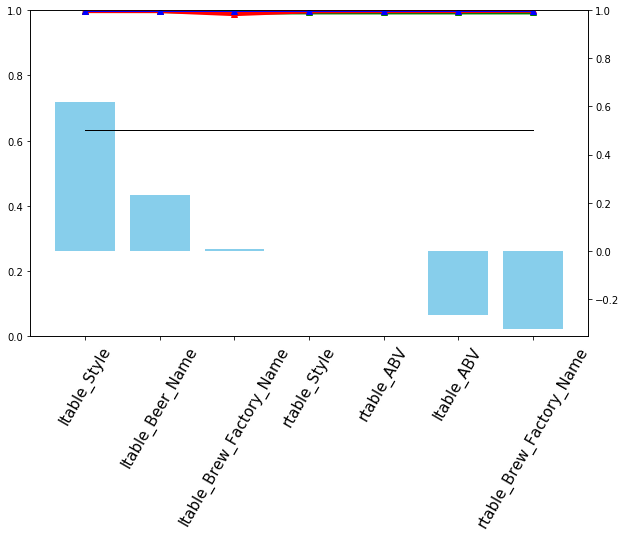

0.9985583424568176
rand
[0.99855834, 0.4975755, 0.9704968, 0.9990262, 0.9966114, 0.9988154, 0.9937111]
[0.99855834, 0.4975755, 0.1373457, 0.21627264, 0.101841286, 0.09737313, 0.052741807]


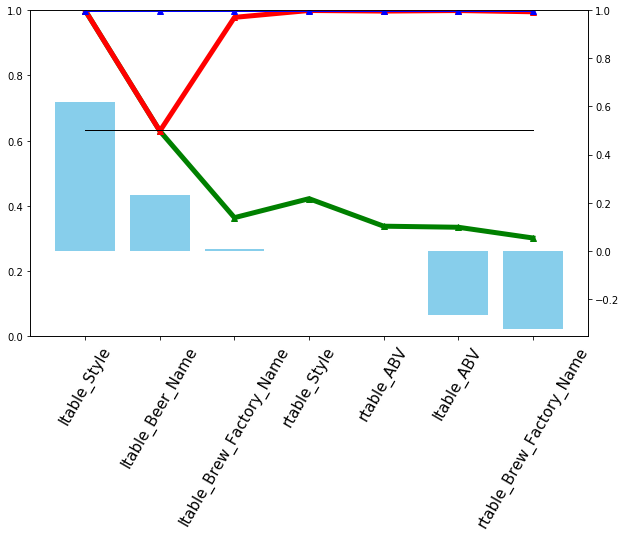

0.6941395998001099
mask
[0.6864893, 0.094059594, 0.66260725, 0.01658893, 0.5187395, 0.81441206, 0.6625261]
[0.6864893, 0.09629077, 0.14179114, 0.2624949, 0.9999995, 0.99999976, 0.99999917]


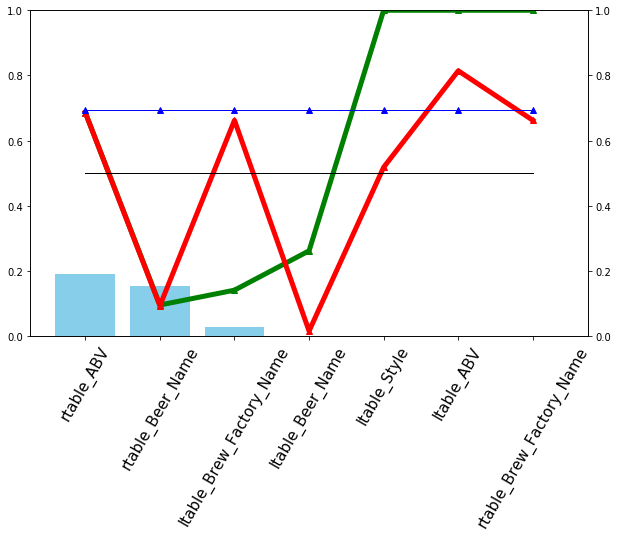

0.6941395998001099
copy
[0.612117, 0.97078687, 0.7941296, 0.17117958, 0.70272803, 0.8101154, 0.6671456]
[0.612117, 0.9541789, 0.9822512, 0.9822512, 0.98230296, 0.98230296, 0.98230296]


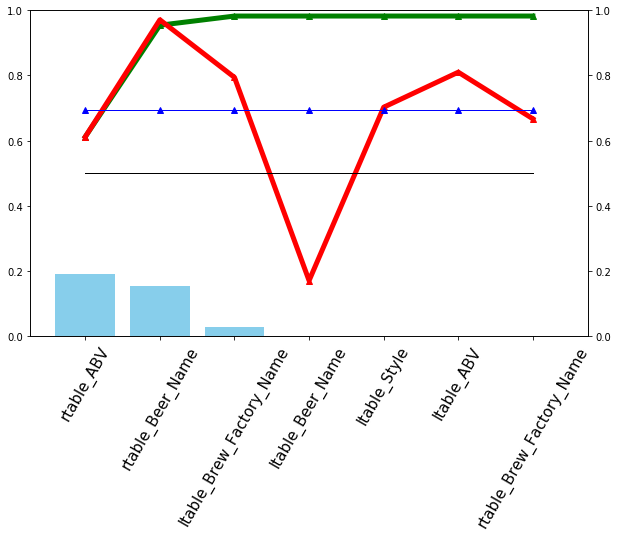

0.6941395998001099
rand
[0.883889, 0.8943935, 0.6850693, 0.01658893, 0.6941396, 0.8065674, 0.68005395]
[0.883889, 0.97850776, 0.9748291, 0.9102905, 0.9102905, 0.95975524, 0.9013211]


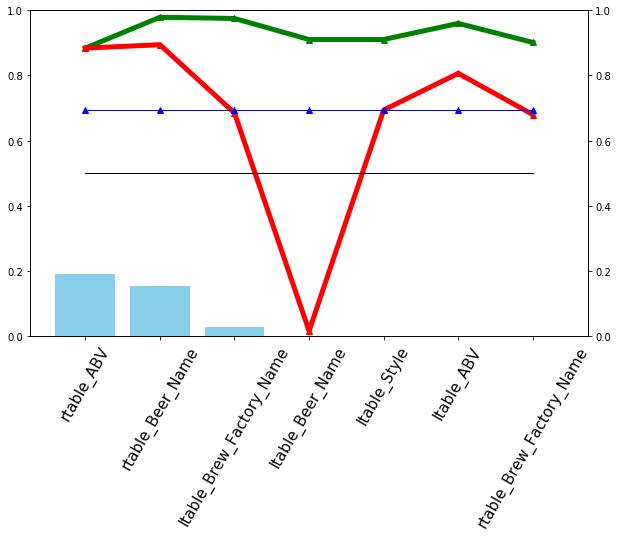

0.9789911508560181
mask
[0.04786827, 0.98124874, 0.019734304, 0.9855122, 0.97505176, 0.971855, 0.94731766]
[0.04786827, 0.031129297, 0.13558508, 0.15543458, 0.99957544, 0.9999008, 0.9999963]


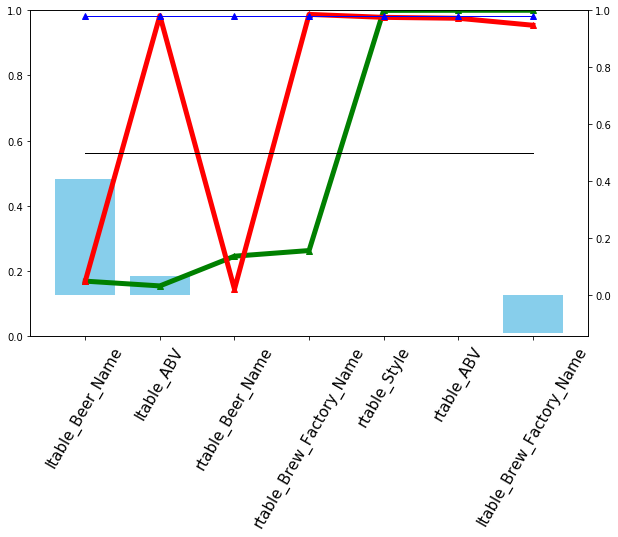

0.9789911508560181
copy
[0.44346195, 0.97740936, 0.999997, 0.9561438, 0.9872204, 0.97633946, 0.99117696]
[0.44346195, 0.33935896, 0.33935896, 0.88950086, 0.8844923, 0.8844923, 0.8844923]


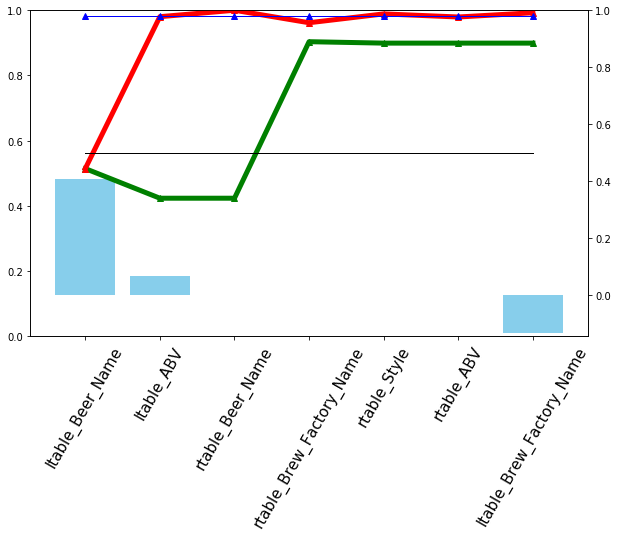

0.9789911508560181
rand
[0.01658893, 0.97516596, 0.01658893, 0.9714399, 0.97899115, 0.9720916, 0.93695825]
[0.01658893, 0.01658893, 0.01658893, 0.030332943, 0.030332943, 0.029958462, 0.028183913]


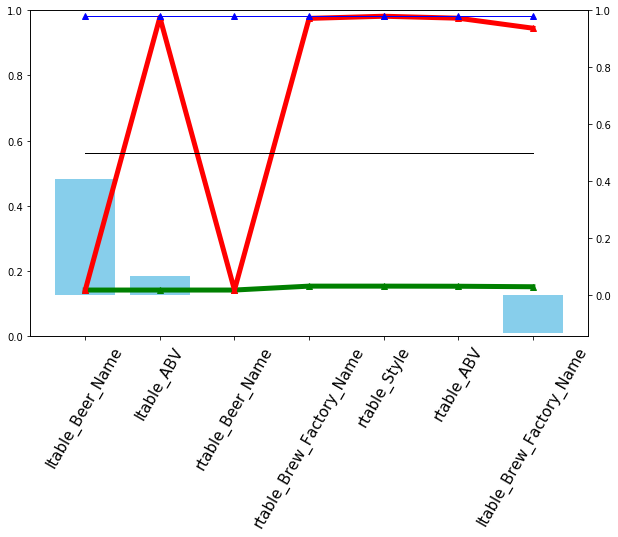

0.016588930040597916
mask
[0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893]
[0.01658893, 0.01658893, 0.018356647, 0.050116505, 0.028906316, 0.023563813, 0.99869967]


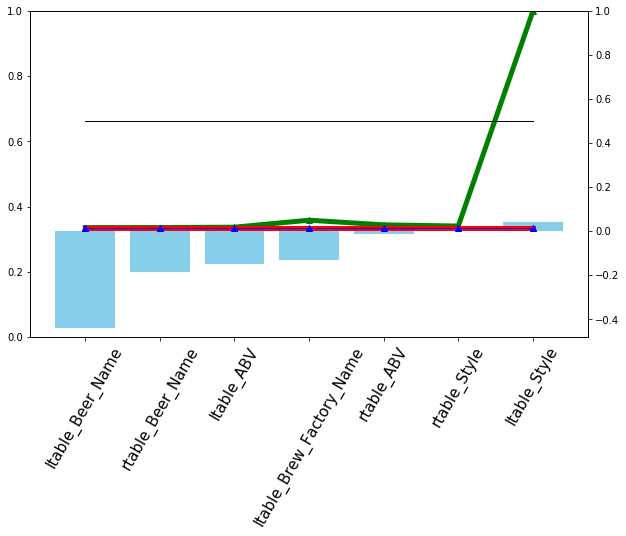

0.016588930040597916
copy
[0.13565099, 0.38168356, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893]
[0.13565099, 0.13565099, 0.16378474, 0.15215059, 0.15215059, 0.30368212, 0.30368212]


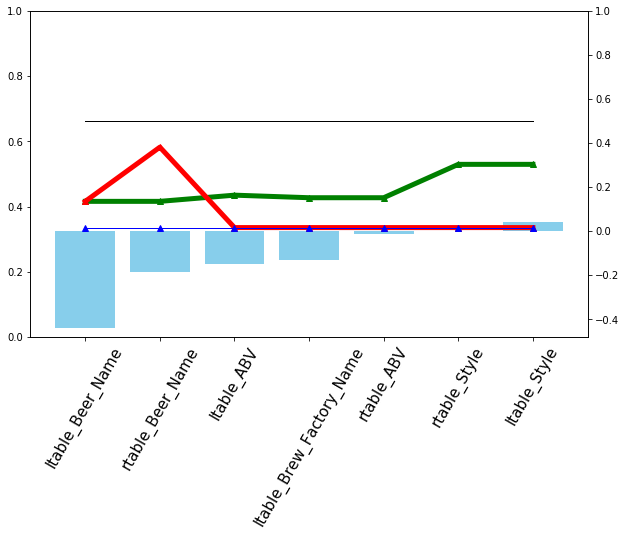

0.016588930040597916
rand
[0.075981855, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893]
[0.075981855, 0.04660987, 0.061411783, 0.074878834, 0.074878834, 0.08020341, 0.08020341]


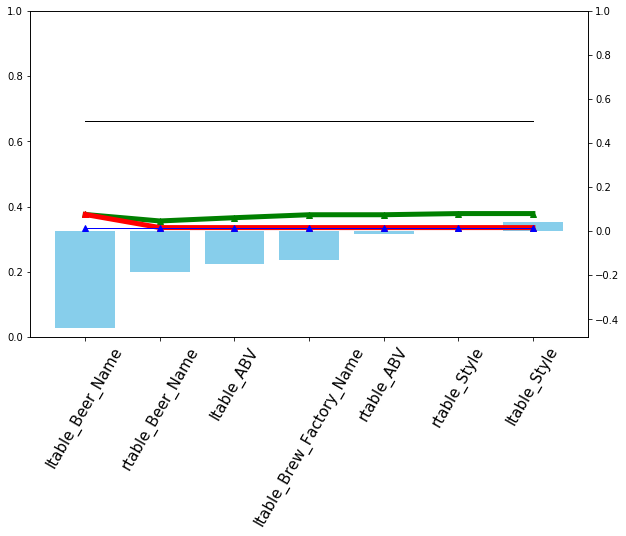

0.016588930040597916
mask
[0.8929399, 0.088095576, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893]
[0.8929399, 0.72565216, 0.722338, 0.3454688, 0.38270217, 0.99975437, 0.9999963]


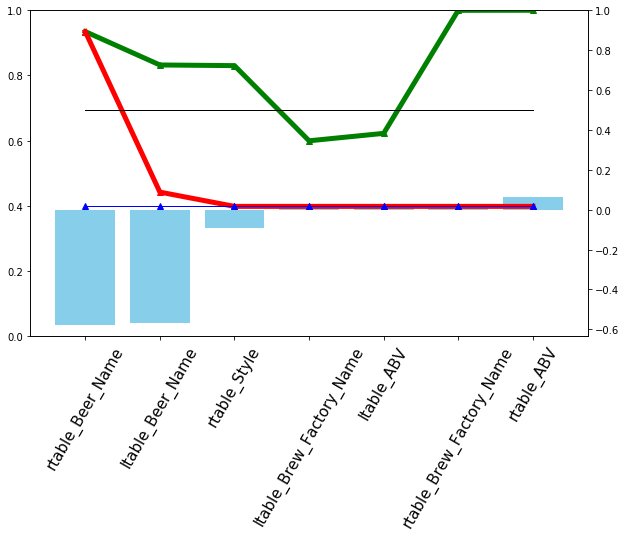

0.016588930040597916
copy
[0.9999497, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893]
[0.9999497, 0.9999497, 0.9999765, 0.99999475, 0.9999949, 0.9999949, 0.9999949]


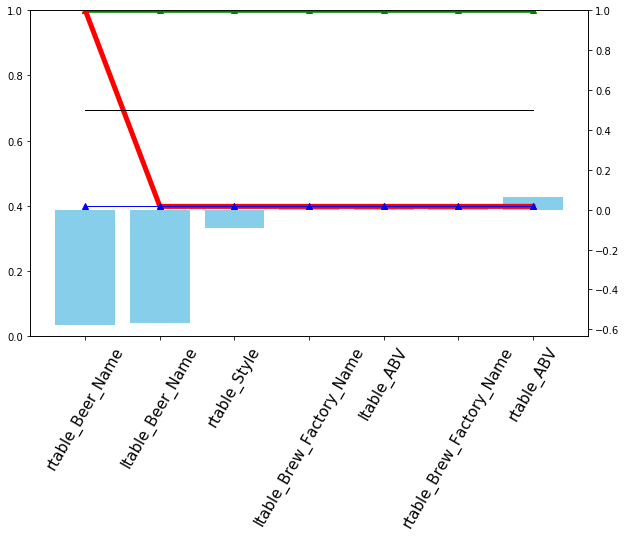

0.016588930040597916
rand
[0.29862922, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893]
[0.29862922, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.041526433, 0.11781991]


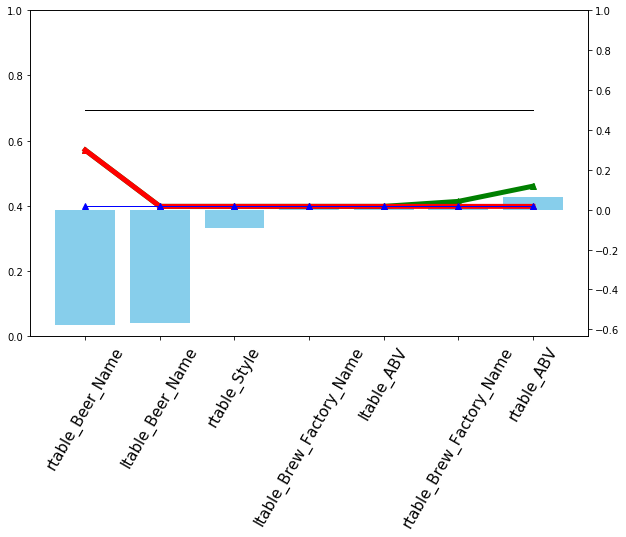

0.5825655460357666
mask
[0.040085513, 0.5334703, 0.63825387, 0.8860878, 0.4581605, 0.56617254, 0.2317003]
[0.040085513, 0.036363747, 0.027082747, 0.9999311, 0.99993145, 0.99999964, 0.99999964]


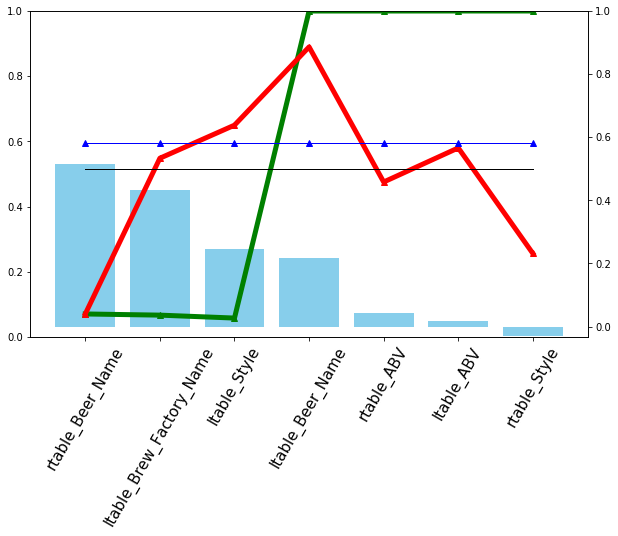

0.5825655460357666
copy
[0.70894027, 0.46503752, 0.6113004, 0.9991441, 0.58256555, 0.58256555, 0.6319091]
[0.70894027, 0.5479699, 0.55391973, 0.55391973, 0.55391973, 0.55391973, 0.55391973]


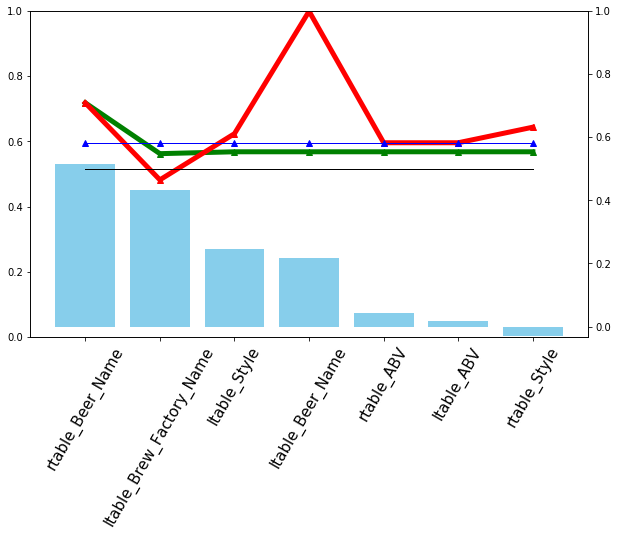

0.5825655460357666
rand
[0.01658893, 0.43326208, 0.58256555, 0.5340952, 0.6468447, 0.65788996, 0.5796177]
[0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.020132218, 0.032848805, 0.030115653]


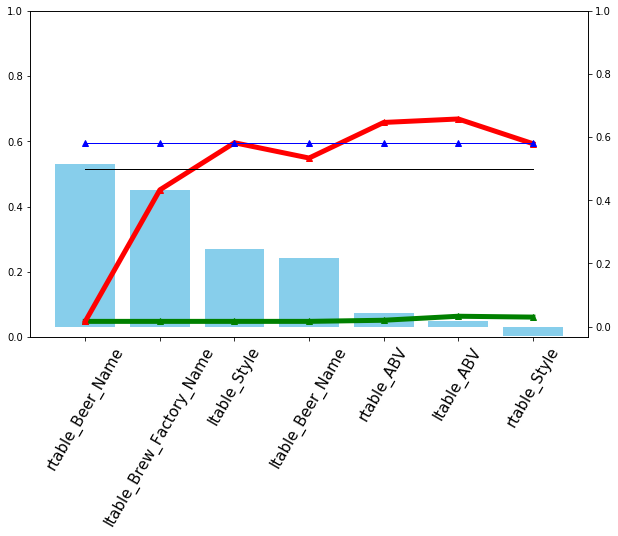

0.016588930040597916
mask
[0.052896123, 0.01658893, 0.01658893, 0.034294024, 0.01658893, 0.01658893, 0.01658893]
[0.052896123, 0.05921487, 0.01658893, 0.15437773, 0.9999839, 0.9999883, 0.9991948]


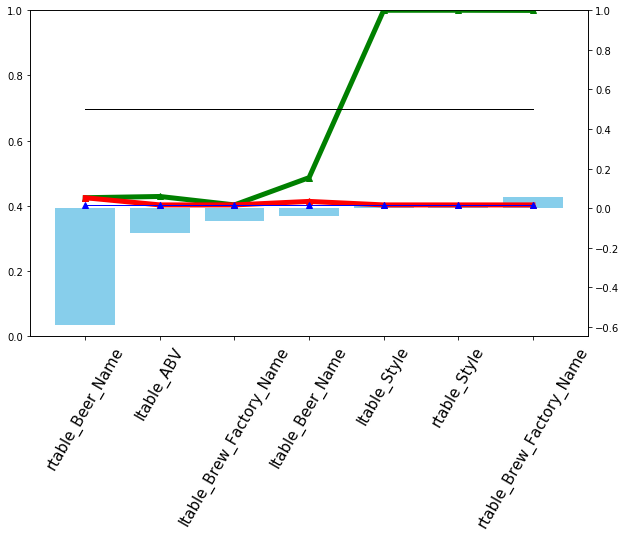

0.016588930040597916
copy
[0.9711483, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.023515701]
[0.9711483, 0.97248334, 0.99989223, 0.99989223, 0.9999213, 0.9999213, 0.9999213]


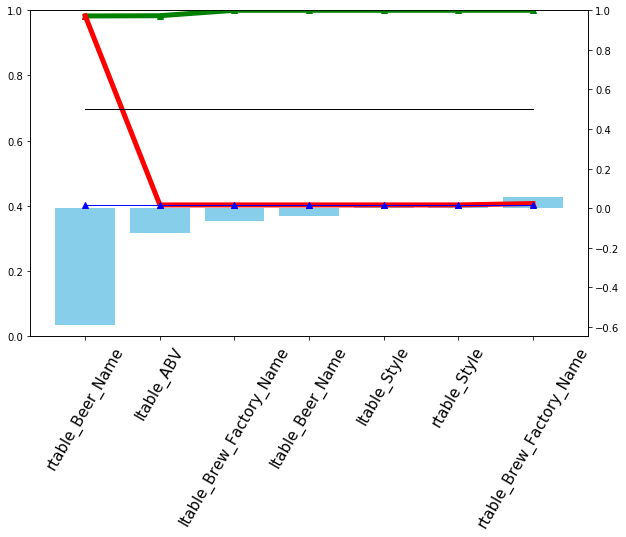

0.016588930040597916
rand
[0.01658893, 0.01658893, 0.01658893, 0.10627611, 0.01658893, 0.01658893, 0.01658893]
[0.01658893, 0.01658893, 0.01658893, 0.30293843, 0.30293843, 0.29807717, 0.49952883]


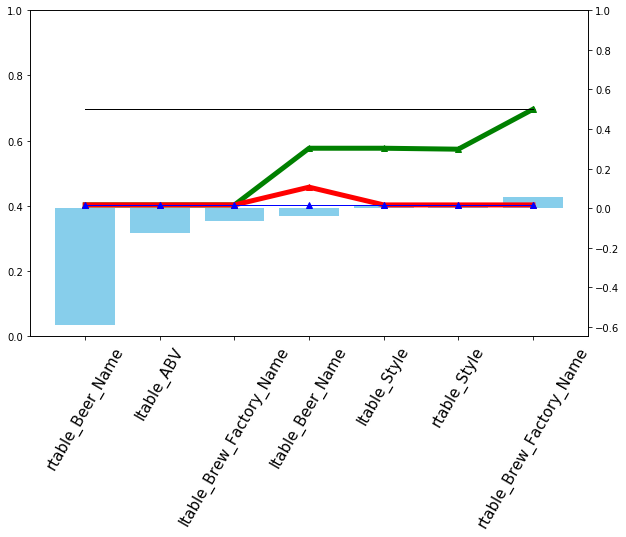

0.01998080313205719
mask
[0.42403457, 0.3938582, 0.0267854, 0.018602736, 0.026697436, 0.020151898, 0.01658893]
[0.42403457, 0.72023755, 0.7841754, 0.9999603, 0.9999627, 0.99956065, 0.99918145]


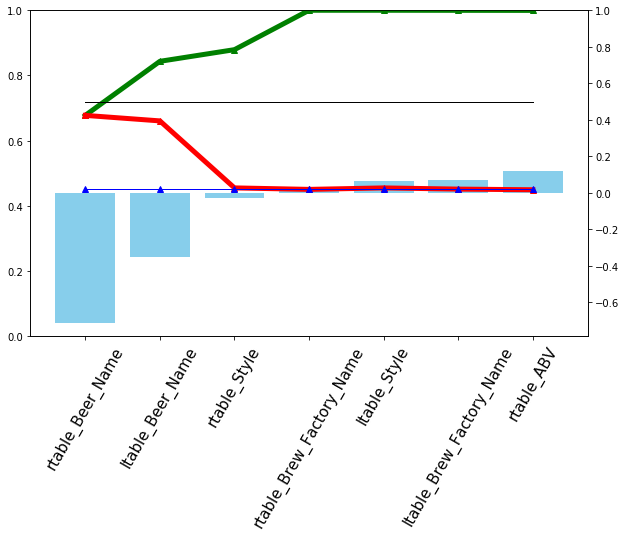

0.01998080313205719
copy
[0.9187911, 0.39391434, 0.017707014, 0.019980803, 0.01916942, 0.019980803, 0.019980803]
[0.9187911, 0.9187911, 0.91106075, 0.91106075, 0.91106075, 0.91106075, 0.91106075]


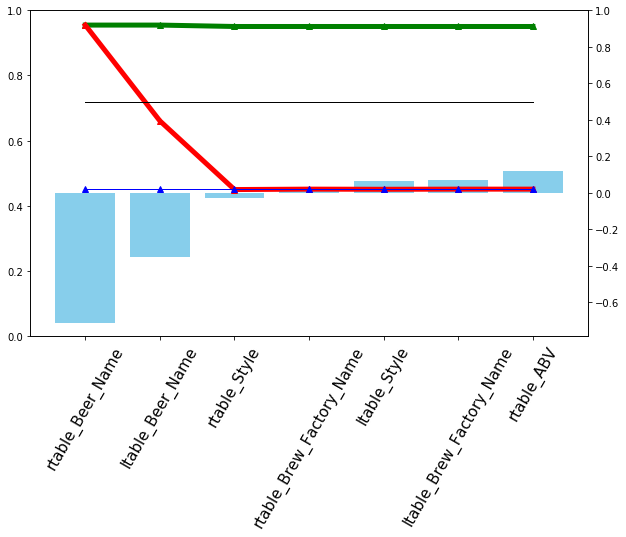

0.01998080313205719
rand
[0.20329776, 0.2890672, 0.01949791, 0.022681631, 0.019980803, 0.01658893, 0.025807235]
[0.20329776, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893]


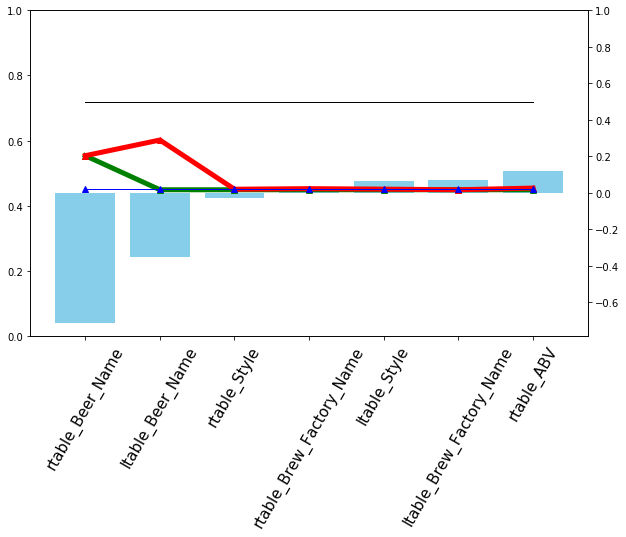

0.16183564066886902
mask
[0.19046676, 0.14710416, 0.01658893, 0.16639338, 0.15551376, 0.15316817, 0.16026576]
[0.19046676, 0.17283699, 0.01658893, 0.9905363, 0.9810019, 0.9979697, 0.99847776]


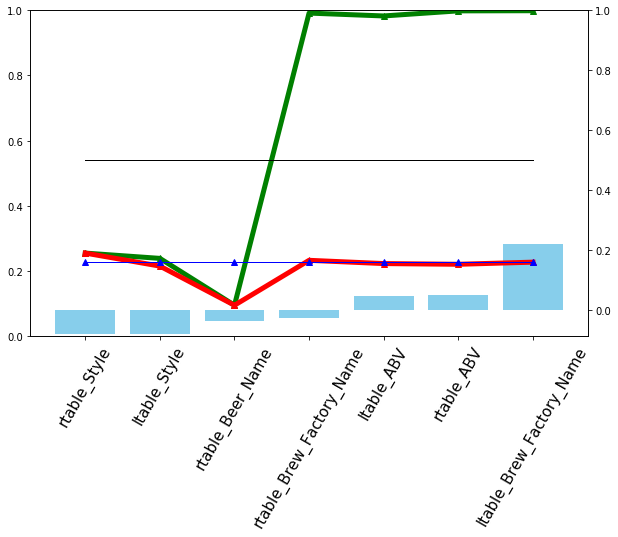

0.16183564066886902
copy
[0.15290676, 0.16104665, 0.35086417, 0.16262425, 0.14108868, 0.18636298, 0.16588794]
[0.15290676, 0.15290676, 0.33283386, 0.34380403, 0.30746675, 0.30746675, 0.30746675]


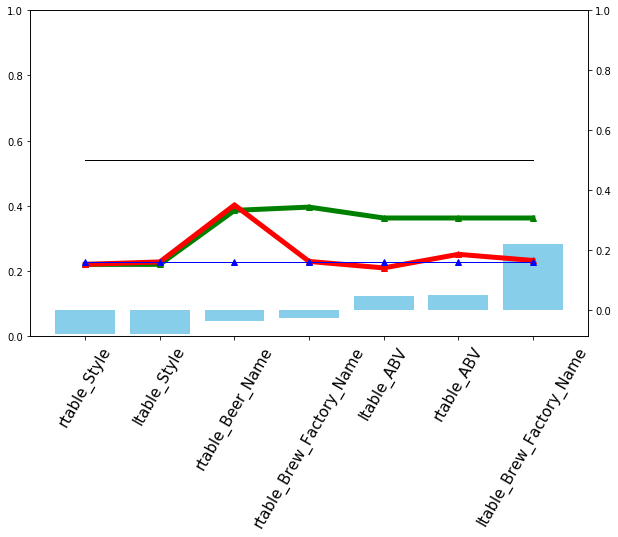

0.16183564066886902
rand
[0.16183564, 0.14665785, 0.01658893, 0.16596295, 0.13468759, 0.47949296, 0.17981605]
[0.16183564, 0.14665785, 0.01658893, 0.01658893, 0.01658893, 0.020607479, 0.01719193]


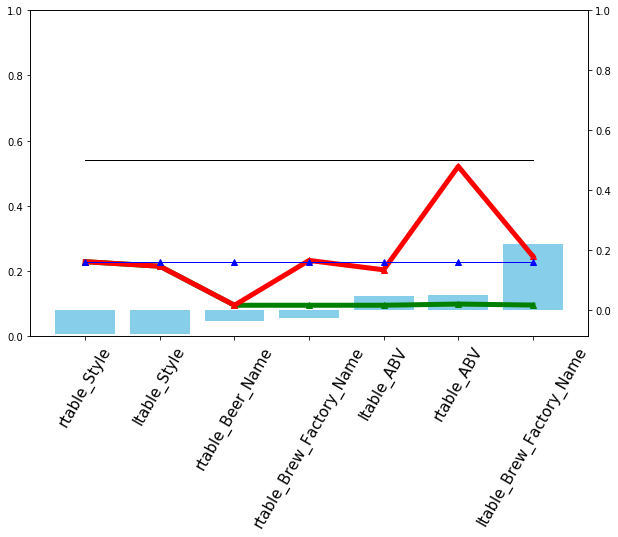

0.06117797642946243
mask
[0.32706833, 0.062281758, 0.08493451, 0.041148596, 0.060234893, 0.020625712, 0.018950403]
[0.32706833, 0.50277543, 0.9991153, 0.99972576, 0.9998535, 0.9999124, 0.99990153]


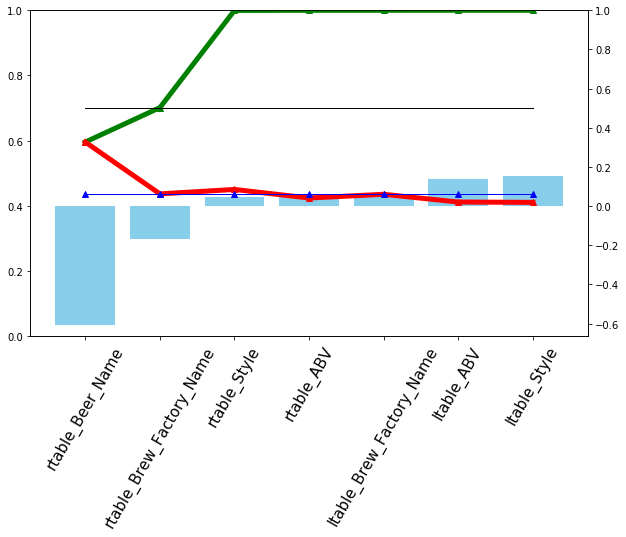

0.06117797642946243
copy
[0.64013296, 0.0500464, 0.020187587, 0.06701698, 0.57417876, 0.025899215, 0.017492274]
[0.64013296, 0.5630322, 0.7405688, 0.8945132, 0.8945132, 0.8945132, 0.8945132]


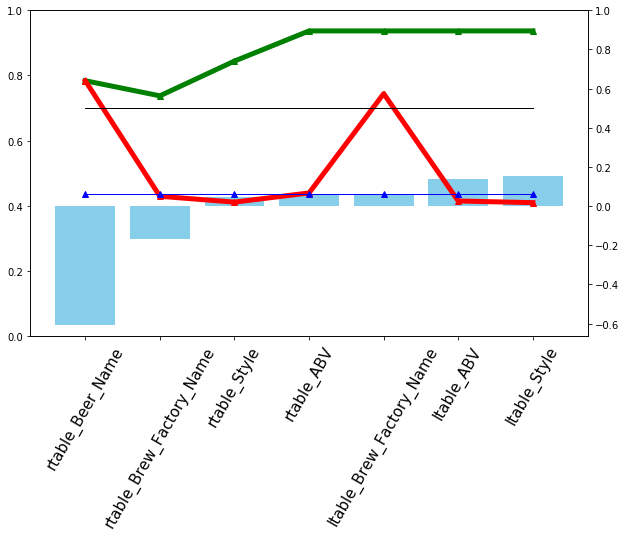

0.06117797642946243
rand
[0.039592374, 0.058836926, 0.054057546, 0.056183375, 0.5766475, 0.017692182, 0.061177976]
[0.039592374, 0.054185946, 0.06025782, 0.04770508, 0.5482788, 0.46708888, 0.46708888]


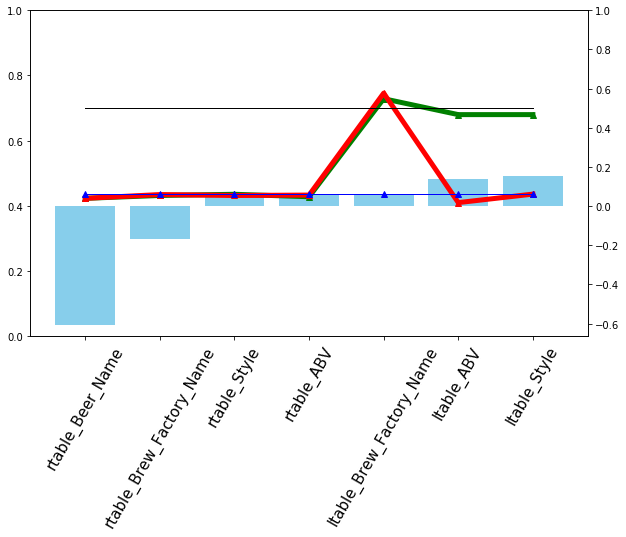

0.9985583424568176
mask
[0.033820607, 0.0847195, 0.9984693, 0.99982005, 0.9997806, 0.99705935, 0.9988199]
[0.033820607, 0.13848595, 0.13699454, 0.21924075, 0.999887, 0.99999666, 0.9999949]


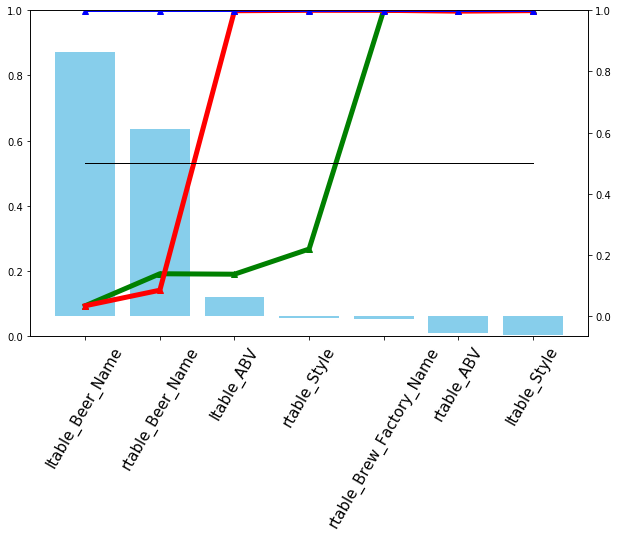

0.9985583424568176
copy
[0.99855834, 0.99855834, 0.99855834, 0.99750745, 0.999887, 0.99855834, 0.9987344]
[0.99855834, 0.99855834, 0.99855834, 0.99750745, 0.9998561, 0.9998561, 0.9998561]


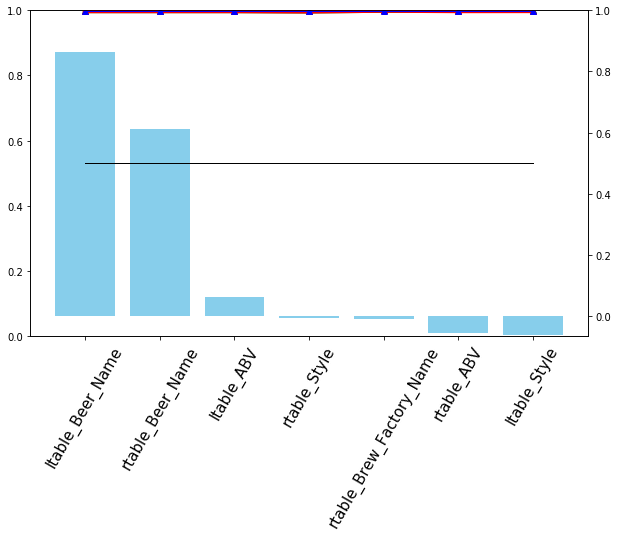

0.9985583424568176
rand
[0.15431303, 0.8205389, 0.99881566, 0.99855834, 0.9913071, 0.99841547, 0.99855834]
[0.15431303, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893]


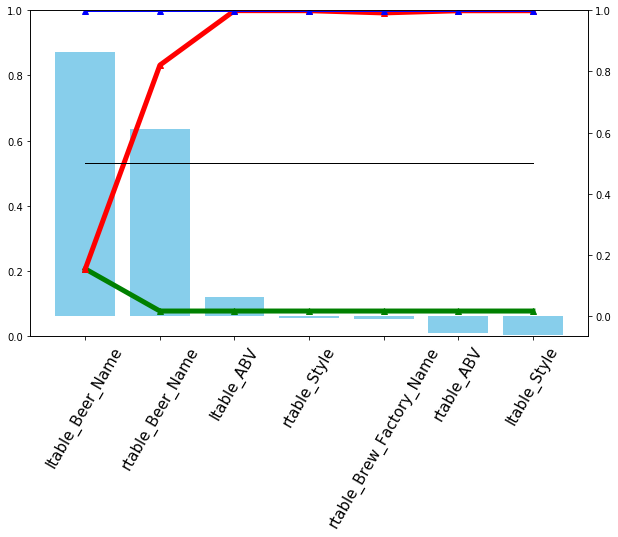

0.6941395998001099
mask
[0.01658893, 0.66260725, 0.5187395, 0.6625261, 0.094059594, 0.6491936, 0.6864893]
[0.01658893, 0.01658893, 0.990928, 0.9917801, 0.9999888, 0.99730945, 0.9967392]


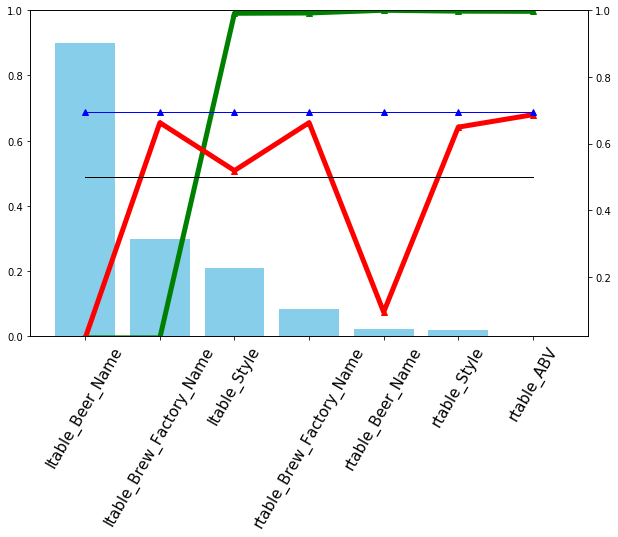

0.6941395998001099
copy
[0.17117958, 0.7941296, 0.70272803, 0.6671456, 0.97078687, 0.64609647, 0.612117]
[0.17117958, 0.15107103, 0.1745778, 0.1745778, 0.1745778, 0.1745778, 0.10517203]


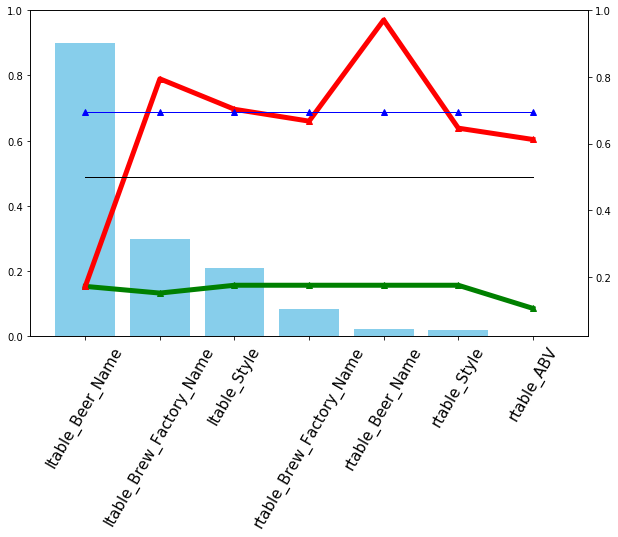

0.6941395998001099
rand
[0.22249824, 0.70840746, 0.6941396, 0.67239654, 0.07146396, 0.68431896, 0.6581945]
[0.22249824, 0.33572206, 0.33572206, 0.27552706, 0.10633351, 0.096388936, 0.082493685]


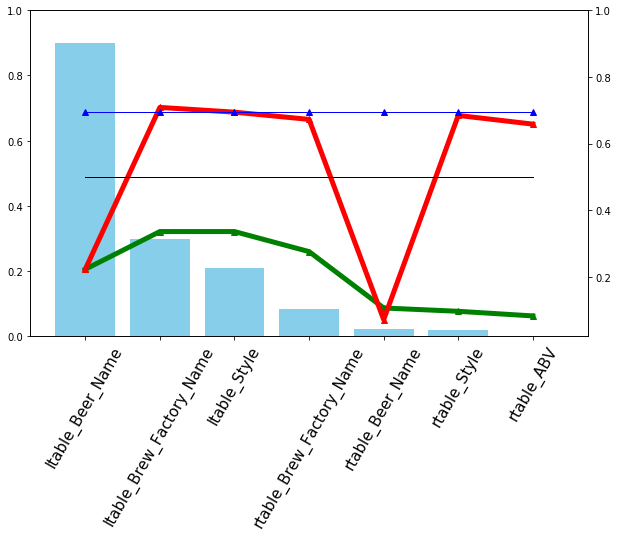

0.9789911508560181
mask
[0.04786827, 0.019734304, 0.971855, 0.9855122, 0.67213714, 0.97505176, 0.94731766]
[0.04786827, 0.20141011, 0.101437196, 0.08485051, 0.08281762, 0.9993505, 0.99969494]


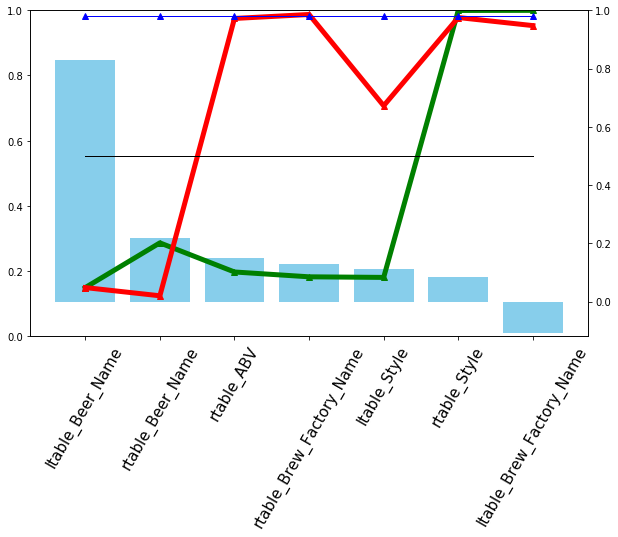

0.9789911508560181
copy
[0.44346195, 0.999997, 0.97633946, 0.9561438, 0.9580338, 0.9872204, 0.99117696]
[0.44346195, 0.44346195, 0.43893057, 0.9253974, 0.9295156, 0.9295156, 0.9295156]


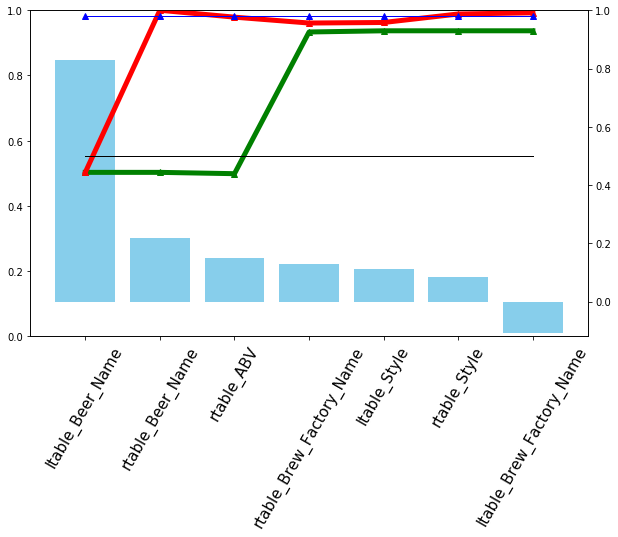

0.9789911508560181
rand
[0.21441348, 0.43251556, 0.9896673, 0.9824843, 0.97899115, 0.97899115, 0.81918925]
[0.21441348, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893, 0.01658893]


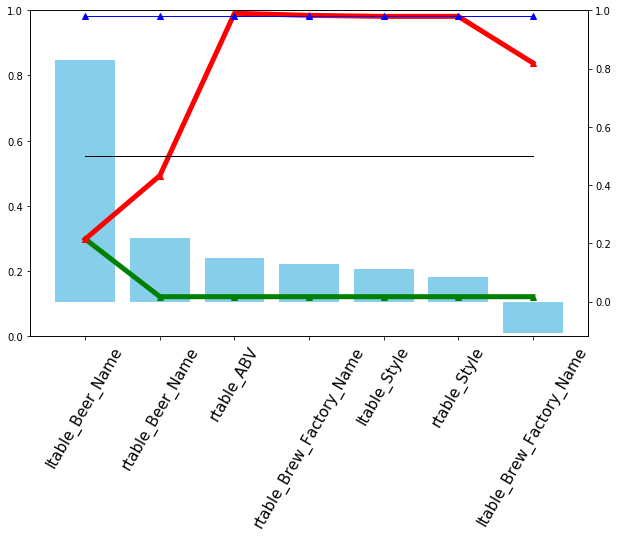

In [82]:
for etype in ['certa', 'mojito', 'shap', 'landmark']:
    for i in range(10):
        rand_row =  test_df.iloc[i]
        l_id = int(rand_row['ltable_id'])
        label = rand_row["label"]
        l_tuple = lsource.iloc[l_id]
        r_id = int(rand_row['rtable_id'])
        r_tuple = rsource.iloc[r_id]
        saliency_df = pd.DataFrame(eval(explanations[etype].iloc[i]['explanation']),index=[0])
        for perturb in ['mask','copy','rand']:
            try:
                saliency_graph(saliency_df, l_tuple, r_tuple, predict_fn, nm=7, pred=float(predict_fn(get_row(l_tuple,r_tuple))['match_score'][0]),
                           perturb=perturb, path='/home/tteofili/dev/certem/data_new/BA/'+model_dir+'/'+str(i)+'/sg/'+etype+'_'+perturb+'.png', etype=etype)
            except:
                pass